In [189]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42

from sklearn.preprocessing import  StandardScaler # LabelEncoder, RobustScaler, MinMaxScaler,

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression,  SGDRegressor, Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, StackingClassifier
 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split #cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold, LeaveOneOut, cross_validate


from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, roc_curve, roc_auc_score, f1_score, median_absolute_error #auc,
#from sklearn import metrics

from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import os, sys
import optuna
import pickle

# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

!pip freeze > requirements.txt

In [75]:
from utils.reader_config import config_reader

# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
from optuna.samplers import TPESampler
sampler = TPESampler(seed=random_seed) # fix random seed


## Read files

In [76]:
xlsx = pd.ExcelFile('../data/Data.xlsx')
# sheet names
xlsx.sheet_names

['Demography',
 'Products_and_Balances',
 'Inflow_and_Outflows',
 'Sales_Revenues']

In [77]:
Demography = pd.read_excel(xlsx, 'Demography')
Demography.tail()

,Client_id,Sex,Age,Tenure
1605,1606,M,35,118
1606,1607,F,48,139
1607,1608,M,41,97
1608,1609,M,20,127
1609,1610,F,19,226


In [78]:
Products_and_Balances = pd.read_excel(xlsx, 'Products_and_Balances')
Products_and_Balances.tail()

,Client_id,Count_CA,Count_SA,Count_MFunds,...,ActBalance_Mfunds,ActBalance_OVD,ActBalance_Ccards,ActBalance_CLoans
1605,1606,1,NaN,2.0,...,1539.726315,NaN,NaN,NaN
1606,1607,1,NaN,NaN,...,NaN,9.735734,NaN,NaN
1607,1608,1,NaN,6.0,...,22092.358822,NaN,NaN,NaN
1608,1609,1,NaN,NaN,...,NaN,25.218944,NaN,NaN
1609,1610,1,NaN,NaN,...,NaN,154.046654,146.312001,4874.117734


In [79]:
Inflow_and_Outflows = pd.read_excel(xlsx, 'Inflow_and_Outflows')
Inflow_and_Outflows.tail()

,Client_id,VolumeCredit,VolumeCredit_CA,TransactionsCredit,...,TransactionsDebit_CA,TransactionsDebitCash_Card,TransactionsDebitCashless_Card,TransactionsDebit_PaymentOrder
1575,1576,6517.787417,3579.566024,3,...,11,1,6,3
1576,1577,2829.721652,1924.050750,7,...,13,2,11,3
1577,1578,46.375895,33.585248,5,...,15,8,10,2
1578,1579,3444.004143,1986.221403,4,...,3,0,1,2
1579,1580,8842.188797,7160.096742,9,...,9,1,6,7


In [80]:
Sales_Revenues = pd.read_excel(xlsx, 'Sales_Revenues')
Sales_Revenues.tail()

,Client_id,Sales_MFunds,Sales_CCards,Sales_CLoans,Revenue_MFunds,Revenue_CCards,Revenue_CLoans
955,511,1,1,0,14.601348,17.575660,0.0
956,679,1,1,0,10.051317,20.210774,0.0
957,222,1,1,0,13.865557,16.586769,0.0
958,182,1,1,0,13.853375,39.003065,0.0
959,143,1,1,0,17.342494,40.034095,0.0


In [81]:
# Merge features
merged = Demography.merge(Inflow_and_Outflows, on='Client_id', how='left')
merged

,Client_id,Sex,Age,Tenure,...,TransactionsDebit_CA,TransactionsDebitCash_Card,TransactionsDebitCashless_Card,TransactionsDebit_PaymentOrder
0,1,M,66,93,...,14.0,2.0,3.0,4.0
1,2,M,56,120,...,39.0,4.0,25.0,22.0
2,3,M,59,39,...,22.0,3.0,8.0,4.0
3,4,M,53,119,...,11.0,1.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...
1606,1607,F,48,139,...,NaN,NaN,NaN,NaN
1607,1608,M,41,97,...,NaN,NaN,NaN,NaN
1608,1609,M,20,127,...,NaN,NaN,NaN,NaN
1609,1610,F,19,226,...,NaN,NaN,NaN,NaN


In [82]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1610 entries, 0 to 1609
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Client_id                       1610 non-null   int64  
 1   Sex                             1609 non-null   object 
 2   Age                             1610 non-null   int64  
 3   Tenure                          1610 non-null   int64  
 4   VolumeCredit                    1580 non-null   float64
 5   VolumeCredit_CA                 1580 non-null   float64
 6   TransactionsCredit              1580 non-null   float64
 7   TransactionsCredit_CA           1580 non-null   float64
 8   VolumeDebit                     1580 non-null   float64
 9   VolumeDebit_CA                  1580 non-null   float64
 10  VolumeDebitCash_Card            1580 non-null   float64
 11  VolumeDebitCashless_Card        1580 non-null   float64
 12  VolumeDebit_PaymentOrder        15

Let us select clients, who has return on consumer loans, mutal funds, and credit cards

In [83]:
Sales_Revenues.describe()

,Client_id,Sales_MFunds,Sales_CCards,Sales_CLoans,Revenue_MFunds,Revenue_CCards,Revenue_CLoans
count,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000
mean,480.500000,0.283333,0.368750,0.442708,4.261074,9.766120,5.202384
std,277.272429,0.450852,0.482717,0.496966,7.352755,16.564234,9.033302
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,240.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,480.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,720.250000,1.000000,1.000000,1.000000,9.583259,20.132111,9.739424
max,960.000000,1.000000,1.000000,1.000000,40.562057,222.970867,207.103652


In [84]:
# prospective_clients1 = Sales_Revenues[(Sales_Revenues['Sales_MFunds']==1) & 
#                ((Sales_Revenues['Sales_CCards']==1) & (Sales_Revenues['Sales_CLoans']==0)) | 
#                ((Sales_Revenues['Sales_CCards']==0) & (Sales_Revenues['Sales_CLoans']==1))]

prospective_clients = Sales_Revenues.sort_values(by=['Revenue_CLoans', 'Revenue_CCards', 'Revenue_MFunds'], ascending=[False, False, False])
print('Number of prospective clients: ',prospective_clients.shape[0])
prospective_clients.head()

Number of prospective clients:  960


,Client_id,Sales_MFunds,Sales_CCards,Sales_CLoans,Revenue_MFunds,Revenue_CCards,Revenue_CLoans
0,570,0,1,1,0.000000,32.06813,207.103652
1,159,0,0,1,0.000000,0.00000,31.705530
2,399,0,0,1,0.000000,0.00000,25.323338
3,572,1,0,1,9.887664,0.00000,23.625281
4,55,1,0,1,12.232862,0.00000,23.316691


In [85]:
merged_prospective = merged.merge(prospective_clients, on='Client_id', how='outer')

df_cleaned = merged_prospective.sort_values(by='Revenue_CLoans',ascending=False).dropna()
df_cleaned

,Client_id,Sex,Age,Tenure,...,Sales_CLoans,Revenue_MFunds,Revenue_CCards,Revenue_CLoans
569,570,F,65,150,...,1.0,0.000000,32.068130,207.103652
158,159,F,42,133,...,1.0,0.000000,0.000000,31.705530
398,399,M,47,210,...,1.0,0.000000,0.000000,25.323338
571,572,F,46,177,...,1.0,9.887664,0.000000,23.625281
...,...,...,...,...,...,...,...,...,...
539,540,F,14,52,...,0.0,0.000000,20.709193,0.000000
189,190,M,43,21,...,0.0,0.000000,35.316708,0.000000
542,543,F,44,36,...,0.0,9.375814,0.000000,0.000000
480,481,F,18,72,...,0.0,13.883151,0.000000,0.000000


## Entries for prediction

In [86]:
df1 = merged.merge(prospective_clients, on='Client_id', how='left')

In [87]:
clients_raw = df1[df1['Sales_CLoans'].isnull()]
clients_raw

,Client_id,Sex,Age,Tenure,...,Sales_CLoans,Revenue_MFunds,Revenue_CCards,Revenue_CLoans
960,961,F,39,59,...,NaN,NaN,NaN,NaN
961,962,M,32,42,...,NaN,NaN,NaN,NaN
962,963,F,62,226,...,NaN,NaN,NaN,NaN
963,964,M,45,179,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1606,1607,F,48,139,...,NaN,NaN,NaN,NaN
1607,1608,M,41,97,...,NaN,NaN,NaN,NaN
1608,1609,M,20,127,...,NaN,NaN,NaN,NaN
1609,1610,F,19,226,...,NaN,NaN,NaN,NaN


In [88]:
# Separation of target features
targets = df_cleaned[['Sales_MFunds','Sales_CCards', 'Sales_CLoans', 'Revenue_MFunds', 'Revenue_CCards', 'Revenue_CLoans']] #'Client'

In [89]:
clients_target = clients_raw[list(targets.columns)]
clients_pool = clients_raw.drop(list(targets.columns), axis=1)
clients_pool.head()

,Client_id,Sex,Age,Tenure,...,TransactionsDebit_CA,TransactionsDebitCash_Card,TransactionsDebitCashless_Card,TransactionsDebit_PaymentOrder
960,961,F,39,59,...,6.0,1.0,2.0,2.0
961,962,M,32,42,...,1.0,2.0,2.0,0.0
962,963,F,62,226,...,18.0,1.0,24.0,13.0
963,964,M,45,179,...,7.0,0.0,1.0,3.0
964,965,F,44,252,...,21.0,4.0,6.0,7.0


### Missing values

In [90]:
cols_null_percent = clients_pool.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

VolumeCredit                      4.615385
VolumeCredit_CA                   4.615385
TransactionsCredit                4.615385
TransactionsCredit_CA             4.615385
                                    ...   
TransactionsDebit_CA              4.615385
TransactionsDebitCash_Card        4.615385
TransactionsDebitCashless_Card    4.615385
TransactionsDebit_PaymentOrder    4.615385
Length: 14, dtype: float64

In [91]:
# Empty nan values
empty = clients_pool[clients_pool['VolumeCredit'].isnull()]
empty

,Client_id,Sex,Age,Tenure,...,TransactionsDebit_CA,TransactionsDebitCash_Card,TransactionsDebitCashless_Card,TransactionsDebit_PaymentOrder
1580,1581,M,7,153,...,NaN,NaN,NaN,NaN
1581,1582,M,43,6,...,NaN,NaN,NaN,NaN
1582,1583,F,20,153,...,NaN,NaN,NaN,NaN
1583,1584,M,42,202,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1606,1607,F,48,139,...,NaN,NaN,NaN,NaN
1607,1608,M,41,97,...,NaN,NaN,NaN,NaN
1608,1609,M,20,127,...,NaN,NaN,NaN,NaN
1609,1610,F,19,226,...,NaN,NaN,NaN,NaN


In [92]:
print('Before cleaning', clients_pool.shape)
clients_pool.drop(list(empty.index), axis=0, inplace=True)
print('After cleaning', clients_pool.shape)

Before cleaning (650, 18)
After cleaning (620, 18)


In [93]:
# Separation of Client id to avoid scaling
client_id, clients_pool = clients_pool[['Client_id']], clients_pool.drop(['Client_id'], axis=1)

## Comparisson of train and prediction data

In [94]:
df_cleaned.agg(['mean', 'std']).T

,mean,std
Client_id,480.457769,277.414017
Age,43.055266,18.687019
Tenure,104.065693,66.917071
VolumeCredit,5034.847930,3678.003756
...,...,...
Sales_CLoans,0.442127,0.496899
Revenue_MFunds,4.265517,7.355302
Revenue_CCards,9.757404,16.570674
Revenue_CLoans,5.196919,9.036427


In [95]:
df_cleaned['Tenure']

569    150
158    133
398    210
571    177
      ... 
539     52
189     21
542     36
480     72
Name: Tenure, Length: 959, dtype: int64

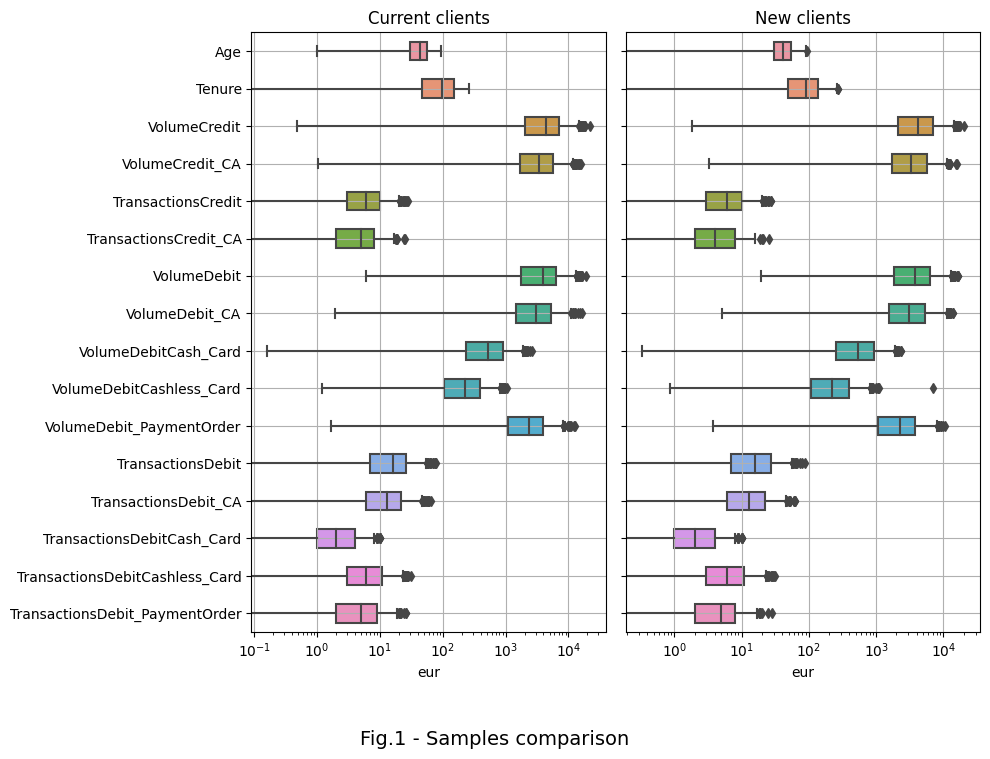

In [96]:
col_display = [ 'Sex', 'Age', 'Tenure', 'VolumeCredit', 'VolumeCredit_CA', 'TransactionsCredit', \
    'TransactionsCredit_CA', 'VolumeDebit', 'VolumeDebit_CA', 'VolumeDebitCash_Card', 'VolumeDebitCashless_Card', \
    'VolumeDebit_PaymentOrder', 'TransactionsDebit', 'TransactionsDebit_CA', 'TransactionsDebitCash_Card', \
    'TransactionsDebitCashless_Card', 'TransactionsDebit_PaymentOrder']

fig_id=1


fig, ax = plt.subplots(1, 2, figsize=(10, 7))

sns.boxplot(
    data=df_cleaned[col_display],
    orient='h',
    width=0.5, ax=ax[0]
)
ax[0].set_title('Current clients')
ax[0].set_xlabel('eur')
ax[0].set_xscale('log')
#plt.tight_layout()
ax[0].grid()

sns.boxplot(
    data=clients_pool,
    orient='h',
    width=0.5, ax=ax[1]
)
ax[1].set_title(f'New clients')
ax[1].set_xlabel('eur')
ax[1].set_xscale('log')
ax[1].yaxis.set_ticklabels([])
plt.tight_layout()
ax[1].grid();
fig.suptitle(f'Fig.{fig_id} - Samples comparison', y=-0.05, fontsize=14)

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

In [97]:
# encoding gender feature
clients_raw_encoded = pd.get_dummies(clients_raw, columns=['Sex'])

# # Let us transform gender from string to numerical
# clients_pool['Sex'] = clients_pool['Sex'].apply(lambda x: 1 if x=='M' else 0)

# 0. Dataset preparation

## Missing entries

In [98]:
cols_null_percent = df_cleaned.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

Series([], dtype: float64)

There is no missing entries in the prepared dataset

In [99]:
df_cleaned.describe()

,Client_id,Age,Tenure,VolumeCredit,...,Sales_CLoans,Revenue_MFunds,Revenue_CCards,Revenue_CLoans
count,959.000000,959.000000,959.000000,959.000000,...,959.000000,959.000000,959.000000,959.000000
mean,480.457769,43.055266,104.065693,5034.847930,...,0.442127,4.265517,9.757404,5.196919
std,277.414017,18.687019,66.917071,3678.003756,...,0.496899,7.355302,16.570674,9.036427
min,1.000000,1.000000,0.000000,0.488575,...,0.000000,0.000000,0.000000,0.000000
25%,240.500000,30.000000,47.000000,2066.676171,...,0.000000,0.000000,0.000000,0.000000
50%,480.000000,43.000000,97.000000,4444.218407,...,0.000000,0.000000,0.000000,0.000000
75%,720.500000,56.000000,153.000000,7142.771737,...,1.000000,9.590418,20.142245,9.730726
max,960.000000,93.000000,260.000000,21730.709932,...,1.000000,40.562057,222.970867,207.103652


### Duplicates

In [100]:
df_cleaned.duplicated().value_counts()

False    959
dtype: int64

There are no duplicated entries in the dataset

## Cleaning of targets from outliers

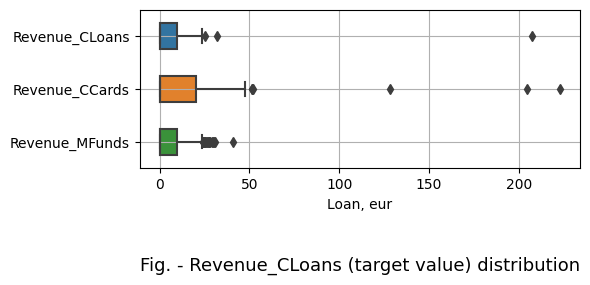

In [101]:
fig = plt.figure(figsize=(6, 4))

fig = sns.boxplot(
    data=df_cleaned[['Revenue_CLoans', 'Revenue_CCards','Revenue_MFunds']],
    #x='Revenue_CLoans',
    orient='h',
    width=0.5
)
fig.set_title('Fig. - Revenue_CLoans (target value) distribution', y=-0.7, fontsize=13)
fig.set_xlabel('Loan, eur')

plt.tight_layout()
fig.grid();

In [102]:
def get_upper_limit(data: pd.DataFrame, features:list, sigma_factor=3):
    """Returns upper limit 

    Args:
        feature (pd.DataFrame): Feature to process
        limit
    """    
    for i, name in enumerate(features):
        mean = data[name].mean()
        std = data[name].std() 
        upper_limit = round(mean + sigma_factor* std)
        print(f'Upper limit for {name} is: ', upper_limit)
        
        data.drop(list(data[data[name]>upper_limit].index), axis=0, inplace=True)
        #return upper_limit


In [103]:
get_upper_limit(df_cleaned, ['Revenue_CLoans', 'Revenue_CCards','Revenue_MFunds'], sigma_factor=3)

Upper limit for Revenue_CLoans is:  32
Upper limit for Revenue_CCards is:  59
Upper limit for Revenue_MFunds is:  26


In [104]:
#df_cleaned.drop(list(df_cleaned[df_cleaned['Revenue_CCards']>20].index), axis=0, inplace=True)

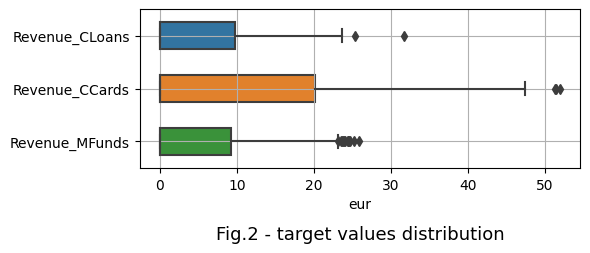

In [105]:
fig = plt.figure(figsize=(6, 3))
fig_id=2

fig = sns.boxplot(
    data=df_cleaned[['Revenue_CLoans', 'Revenue_CCards','Revenue_MFunds']],
    orient='h',
    width=0.5
)
fig.set_title(f'Fig.{fig_id} - target values distribution', y=-0.5, fontsize=13)
fig.set_xlabel('eur')
fig.grid()
plt.tight_layout();

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

### Age

Let us exclude clients which age is below 18 years

In [106]:
display(df_cleaned[df_cleaned['Age']<18])
print('Percent of people under 18 years: ', round(df_cleaned[df_cleaned['Age']<18].shape[0] / df_cleaned.shape[0] * 100,1))

,Client_id,Sex,Age,Tenure,...,Sales_CLoans,Revenue_MFunds,Revenue_CCards,Revenue_CLoans
252,253,F,5,244,...,1.0,0.000000,0.000000,21.480539
847,848,F,9,218,...,1.0,0.000000,0.000000,18.581934
914,915,M,10,143,...,1.0,0.000000,26.455421,17.326127
951,952,F,12,178,...,1.0,0.000000,0.000000,16.432263
...,...,...,...,...,...,...,...,...,...
481,482,F,14,118,...,0.0,20.017277,33.119251,0.000000
562,563,M,13,202,...,0.0,0.000000,21.185592,0.000000
537,538,M,12,171,...,0.0,0.000000,15.615211,0.000000
539,540,F,14,52,...,0.0,0.000000,20.709193,0.000000


Percent of people under 18 years:  9.5


Surprisingly the dataset contains 56 (6.1%) clients whose age is under 18 years

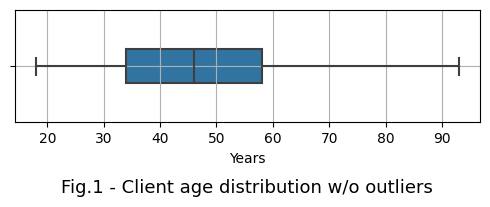

In [107]:
df_cleaned = df_cleaned[df_cleaned['Age']>=18]

fig = plt.figure(figsize=(5, 3))

fig = sns.boxplot(
    data=df_cleaned,
    x='Age',
    orient='h',
    width=0.3
)
fig.set_title('Fig.1 - Client age distribution w/o outliers', y=-0.7, fontsize=13)
fig.set_xlabel('Years')
plt.tight_layout()
fig.grid();

#plt.savefig('figures/fig_1.png')

### Tenure

Clients whose tenure exceeds its age are likely outliers.

In [108]:
df_cleaned['Tenure'].describe()

count    855.000000
mean     104.022222
std       67.076912
min        0.000000
25%       47.000000
50%       97.000000
75%      154.500000
max      260.000000
Name: Tenure, dtype: float64

In [109]:
mask_tenure_equal_to_age = (\
    (df_cleaned['Tenure'] / 12 > df_cleaned['Age']) & 
    (df_cleaned['Age'] < df_cleaned['Tenure'] / 12 ))
display(df_cleaned[mask_tenure_equal_to_age])

print('Shape before cleaning: ',df_cleaned.shape)
df_cleaned.drop(list(df_cleaned[mask_tenure_equal_to_age].index), axis=0, inplace=True)
print('Shape after cleaning: ',df_cleaned.shape)

,Client_id,Sex,Age,Tenure,...,Sales_CLoans,Revenue_MFunds,Revenue_CCards,Revenue_CLoans


Shape before cleaning:  (855, 24)
Shape after cleaning:  (855, 24)


In [110]:
df_cleaned.describe()

,Client_id,Age,Tenure,VolumeCredit,...,Sales_CLoans,Revenue_MFunds,Revenue_CCards,Revenue_CLoans
count,855.000000,855.000000,855.000000,855.000000,...,855.000000,855.000000,855.000000,855.000000
mean,476.774269,46.387135,104.022222,5010.628928,...,0.436257,4.206834,9.159207,4.939290
std,277.203354,16.252143,67.076912,3672.288346,...,0.496210,7.012837,13.181558,6.288031
min,1.000000,18.000000,0.000000,0.488575,...,0.000000,0.000000,0.000000,0.000000
25%,232.500000,34.000000,47.000000,2061.915770,...,0.000000,0.000000,0.000000,0.000000
50%,476.000000,46.000000,97.000000,4430.562042,...,0.000000,0.000000,0.000000,0.000000
75%,717.500000,58.000000,154.500000,7081.646354,...,1.000000,9.966845,19.816482,9.535965
max,960.000000,93.000000,260.000000,21730.709932,...,1.000000,25.892691,51.953765,31.705530


#### Gender

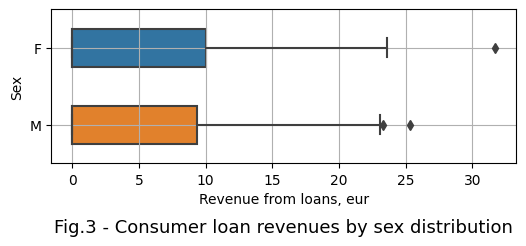

In [111]:
fig = plt.figure(figsize=(6, 2))
fig_id=3

temp_data = df_cleaned
fig = sns.boxplot(
    data=df_cleaned,
    x='Revenue_CLoans',
    y='Sex',
    orient='h',
    width=0.5
)
fig.set_title(f'Fig.{fig_id} - Consumer loan revenues by sex distribution', y=-0.5, fontsize=13)
fig.set_xlabel('Revenue from loans, eur')
fig.grid();

#plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

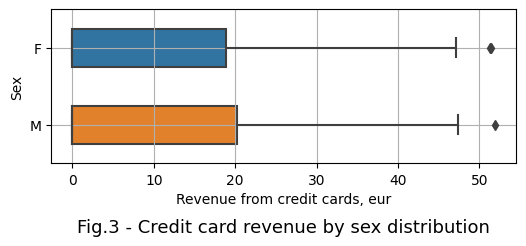

In [112]:
fig = plt.figure(figsize=(6, 2))
#fig_id=3

temp_data = df_cleaned
fig = sns.boxplot(
    data=df_cleaned,
    x='Revenue_CCards',
    y='Sex',
    orient='h',
    width=0.5
)
fig.set_title(f'Fig.{fig_id} - Credit card revenue by sex distribution', y=-0.5, fontsize=13)
fig.set_xlabel('Revenue from credit cards, eur')
fig.grid();

#plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

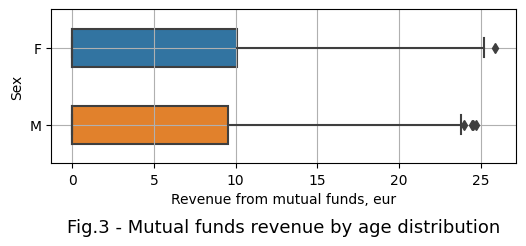

In [113]:
fig = plt.figure(figsize=(6, 2))
#fig_id=3

temp_data = df_cleaned
fig = sns.boxplot(
    data=df_cleaned,
    x='Revenue_MFunds',
    y='Sex',
    orient='h',
    width=0.5
)
fig.set_title(f'Fig.{fig_id} - Mutual funds revenue by age distribution', y=-0.5, fontsize=13)
fig.set_xlabel('Revenue from mutual funds, eur')
fig.grid();

#plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png')

In [114]:
display(df_cleaned['Sex'].value_counts(True).round(2))

# Feature encoding
df_cleaned = pd.get_dummies(df_cleaned, columns=['Sex'])
df_cleaned.head()

M    0.56
F    0.44
Name: Sex, dtype: float64

,Client_id,Age,Tenure,VolumeCredit,...,Revenue_CCards,Revenue_CLoans,Sex_F,Sex_M
158,159,42,133,6917.232821,...,0.0,31.705530,1,0
398,399,47,210,5557.234899,...,0.0,25.323338,0,1
571,572,46,177,11177.394832,...,0.0,23.625281,1,0
54,55,61,71,10772.823560,...,0.0,23.316691,0,1
529,530,41,161,7779.290723,...,0.0,23.214744,1,0


## Features study

In [115]:
df_cleaned
# selection of numerical features
num_features = [s for s in df_cleaned.columns if df_cleaned[s].dtypes != 'object']
df_cleaned[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Client_id,855.0,476.774269,277.203354,1.000000,232.50000,476.000000,717.500000,960.000000
Age,855.0,46.387135,16.252143,18.000000,34.00000,46.000000,58.000000,93.000000
Tenure,855.0,104.022222,67.076912,0.000000,47.00000,97.000000,154.500000,260.000000
VolumeCredit,855.0,5010.628928,3672.288346,0.488575,2061.91577,4430.562042,7081.646354,21730.709932
...,...,...,...,...,...,...,...,...
Revenue_CCards,855.0,9.159207,13.181558,0.000000,0.00000,0.000000,19.816482,51.953765
Revenue_CLoans,855.0,4.939290,6.288031,0.000000,0.00000,0.000000,9.535965,31.705530
Sex_F,855.0,0.440936,0.496790,0.000000,0.00000,0.000000,1.000000,1.000000
Sex_M,855.0,0.559064,0.496790,0.000000,0.00000,1.000000,1.000000,1.000000


In [116]:
def qq_plot(data, features):
    # display pair plots
    for i in data[features]:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        
        sns.histplot(data[i], kde=True, bins=30, ax=ax[0]) # histogram
        ax[0].set_title('Histogram')

        stats.probplot(data[i], plot=ax[1]) # qq plot
        plt.tight_layout() 
        fig.suptitle(f'Feature: {i} \n------------------', y=-0.05)

#qq_plot(df_cleaned, num_features)

In [117]:
#qq_plot(df_cleaned, num_features)

In [118]:
# n = len(num_features) # numerical features
# fig, axes = plt.subplots(n, 2, figsize=(10, 65)) 

# # Cycle to study features
# for i, feature in enumerate(num_features): #i- index, feature    
#     # histogram
#     histplot = sns.histplot(data=df_cleaned[1:], x=feature, ax=axes[i][0])
#     histplot.set_title('{} hist'.format(feature))   
#     histplot.xaxis.set_tick_params(rotation=45)
    
#     # scatter plot with regression
#     regplot = sns.regplot(data=df_cleaned, x=feature, y='Revenue_CLoans', ax=axes[i][1],line_kws={"color": "red"})
#     regplot.set_title('{} VS Revenue_CLoans'.format(feature));
#     regplot.xaxis.set_tick_params(rotation=45)

# plt.tight_layout() 

#### Numerical features study

In [119]:
# # heatmap

# fig = plt.figure(figsize=(14, 9))
# matrix = np.triu(df_cleaned.corr(numeric_only=True))
# sns.heatmap(round(abs(df_cleaned.corr(numeric_only=True)), 2), annot=True, cmap= 'coolwarm', mask=matrix);

In [120]:
# df_cleaned_log = df_cleaned.copy()

# for i in df_cleaned[features_to_log].columns:
#     df_cleaned_log[i] = np.log(df_cleaned_log[i])

# df_cleaned_log.head(2)

In [123]:
# Separation of target features to avoid scaling
targets = df_cleaned[['Sales_MFunds','Sales_CCards', 'Sales_CLoans', 'Revenue_MFunds', 'Revenue_CCards', 'Revenue_CLoans']] 

df_cleaned.drop(['Client_id', 'Sales_MFunds','Sales_CCards', 'Sales_CLoans', 'Revenue_MFunds', 'Revenue_CCards', 'Revenue_CLoans'], axis=1, inplace=True) 

#df_scaled.head()

## Scaling 

In [124]:
scaler = StandardScaler() #RobustScaler()  #MinMaxScaler() #
columns = columns_to_process = ['Age', 'Tenure', 'VolumeCredit', 'VolumeCredit_CA', 'TransactionsCredit', 'TransactionsCredit_CA', 'VolumeDebit', 'VolumeDebit_CA','VolumeDebitCash_Card', 'VolumeDebitCashless_Card','VolumeDebit_PaymentOrder', 'TransactionsDebit', 'TransactionsDebit_CA','TransactionsDebitCash_Card', 'TransactionsDebitCashless_Card','TransactionsDebit_PaymentOrder']
df_transformed = scaler.fit_transform(df_cleaned)

df_scaled = pd.DataFrame(df_transformed, columns=df_cleaned.columns)

# Copy scaled data
data_scaled = df_scaled.copy()
data_scaled.head()

,Age,Tenure,VolumeCredit,VolumeCredit_CA,...,TransactionsDebitCashless_Card,TransactionsDebit_PaymentOrder,Sex_F,Sex_M
0,-0.270100,0.432261,0.519491,0.823243,...,0.564934,0.284215,1.126013,-1.126013
1,0.037732,1.580869,0.148933,-0.039581,...,-0.952401,-1.119081,-0.888089,0.888089
2,-0.023834,1.088608,1.680254,1.080683,...,-0.952401,-0.183550,1.126013,-1.126013
3,0.899661,-0.492592,1.570020,1.138463,...,1.576490,0.284215,-0.888089,0.888089
4,-0.331666,0.849937,0.754375,0.142766,...,-1.120994,-0.183550,1.126013,-1.126013


# 1.1 Consumer loan classifification 

## 1.1.1 Preparation

### Target variable

0.0    0.56
1.0    0.44
Name: Sales_CLoans, dtype: float64


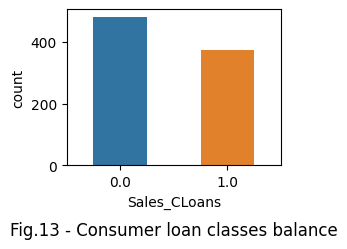

In [125]:
fig_id = 13

fig, ax = plt.subplots(figsize=(3, 3)) 
sns.countplot(data=targets, x='Sales_CLoans', width=0.5)
ax.set_title(f'Fig.{fig_id} - Consumer loan classes balance', y=-0.5)
plt.tight_layout();

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

print(targets['Sales_CLoans'].value_counts(True).round(2))

In [126]:
# separation of the target feature
X, y  = data_scaled, targets['Sales_CLoans'].values #.drop(['Sales_CLoans'], axis=1)

In [127]:
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0. 1.] [482 373]


### Balancing samples

In [128]:
# Synthetic resampling of minority class
sm = SMOTE(random_state=random_seed)
X, y = sm.fit_resample(X, y)

unique, counts = np.unique(y, return_counts=True)
print('After synthetic resampling : ',unique, counts)

After synthetic resampling :  [0. 1.] [482 482]


In [129]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (771, 18)
Test shape:  (96, 18)
Valid shape: (97, 18)


## 1.1.2 Modelling

In [130]:
def get_ROC_plot(model,  X_test, y_test, title:str, fig_id:int=None):
    """
    Create the roc curve plot
    Args:
        model (_type_): pre-trained model to get prediction
        X_valid (_type_): X matrice with 
        y_valid (_type_): y predicted values
        title (_type_): _description_
        figpath (_int_): figure path for saving
    """
    y_pred = model.predict_proba(X_valid)[:,1]
    print('roc_auc: ', roc_auc_score(y_valid, y_pred).round(3))

    false_positive_rates, true_positive_rates, threshold = roc_curve(y_valid, y_pred)


    # Plot
    fig, ax = plt.subplots(figsize=(5, 5))

    # ROC curve
    ax.plot(false_positive_rates, true_positive_rates, 
            label='Smoothed values ROC-AUC')

    # Random model
    ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
            label='Model predicting random')

    ax.set_title(f'Fig.{fig_id} - ROC curve for {title}', y=-0.2)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    ax.fill_between(false_positive_rates, 
                    true_positive_rates, 
                    step="pre", 
                    alpha=0.4, label='Area under curve (ROC-AUC)')
    
    # Annotate figure with ROC cureve
    plt.annotate(f'ROC: {roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1]).round(3)}', xy=(0.45,0.6), textcoords='data', 
             bbox={'facecolor': 'w', 'alpha': 0.95, 'pad': 10} 
    );
    
    ax.legend()
    plt.tight_layout();
    
    if fig_id:
        plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

### Log regression

In [174]:
log_reg = LogisticRegression(
    solver='sag', 
    max_iter=1000,
    random_state=random_seed)

# Model training
log_reg.fit(X_train, y_train) 

# Prediction of target values
y_pred_log, y_pred_log_test = log_reg.predict(X_test), log_reg.predict(X_valid),

# Metrics report
print(classification_report(y_test, y_pred_log))
#print(classification_report(y_valid, y_pred_log_test))

#get_ROC_plot(log_reg, X_test, y_test, 'Log regression CL')

              precision    recall  f1-score   support

         0.0       0.48      0.58      0.53        50
         1.0       0.57      0.47      0.52        59

    accuracy                           0.52       109
   macro avg       0.53      0.53      0.52       109
weighted avg       0.53      0.52      0.52       109



#### Decision tree

In [175]:
# Model creation
model_dt = DecisionTreeClassifier(
    criterion='entropy',  
    max_depth=6,  
    min_samples_leaf=2,  
    random_state=random_seed, 
)
# Model training
model_dt.fit(X_train, y_train)

# Prediction of target values
y_pred_dt = model_dt.predict(X_test)

# Metrics report    
print(classification_report(y_test, y_pred_dt))

#get_ROC_plot(model_dt, X_test, y_test, 'Decision Tree CL')

              precision    recall  f1-score   support

         0.0       0.52      0.74      0.61        50
         1.0       0.66      0.42      0.52        59

    accuracy                           0.57       109
   macro avg       0.59      0.58      0.56       109
weighted avg       0.60      0.57      0.56       109



### Random Forest

              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64        59
         1.0       0.66      0.71      0.68        62

    accuracy                           0.66       121
   macro avg       0.66      0.66      0.66       121
weighted avg       0.66      0.66      0.66       121

roc_auc:  0.744


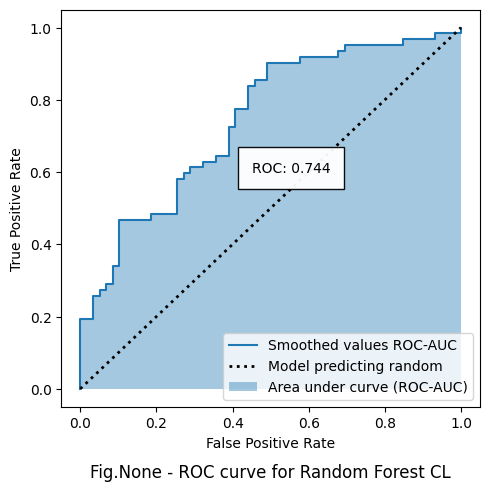

In [249]:
model_rf = RandomForestClassifier(
    n_estimators=110, 
    min_samples_leaf=5,
    max_depth=7,
    #verbose=1, 
    n_jobs=-1, 
    random_state=random_seed)

#Train model
model_rf.fit(X_train, y_train)

# Prediction
y_pred_rf = model_rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

get_ROC_plot(model_rf, X_test, y_test, 'Random Forest CL')

### Gradient boosting

              precision    recall  f1-score   support

         0.0       0.63      0.56      0.59        59
         1.0       0.62      0.69      0.66        62

    accuracy                           0.63       121
   macro avg       0.63      0.63      0.63       121
weighted avg       0.63      0.63      0.63       121

 MAE: 0.37
 MAPE: 9.7e+16

roc_auc:  0.695


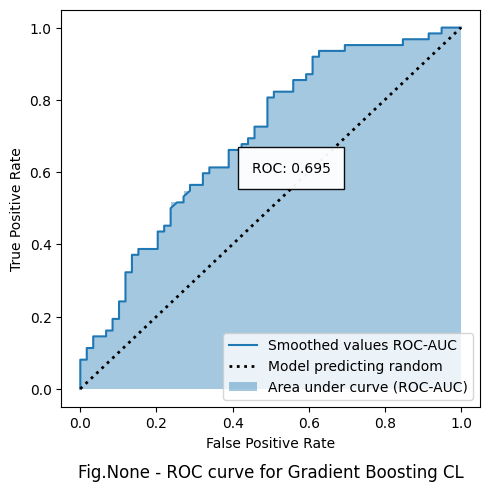

In [250]:
gb = GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=95,
    min_samples_leaf=3,
    max_depth=3,
    random_state=random_seed
)

# train model
gb.fit(X_train, y_train)
 
# Predict target values
y_pred_gb = gb.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb))

print(' MAE: {:.2}'.format(mean_absolute_error(y_test, y_pred_gb)))
print(' MAPE: {:.2}'.format(mean_absolute_percentage_error(y_test, y_pred_gb)*100))
print('')

get_ROC_plot(gb, X_test, y_test, 'Gradient Boosting CL')

### Gradient Boosting + Optuna

In [251]:
def optuna_gb(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 40, 250, 1)
    max_depth = trial.suggest_int('max_depth', 2, 8, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    
    # model creation 
    model = GradientBoostingClassifier(
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=random_seed)
    
    # training
    model.fit(X_train, y_train)
    y_pred = np.round(model.predict_proba(X_test)[:,1])
    F1_score = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred)
    
    return F1_score, roc_score

In [252]:
%%time
sampler = TPESampler(seed=random_seed) # fix random seed

# create study set
study = optuna.create_study(study_name="GradientBoostingClassifier", directions=["maximize", "maximize"], sampler=sampler)
# try multiple times
study.optimize(optuna_gb, n_trials=20)
clear_output(wait=False)

optuna.visualization.plot_pareto_front(study, target_names=["F1_score", "roc_score"])

CPU times: total: 20.8 s
Wall time: 20.8 s


In [253]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

best_hyperparameters = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {best_hyperparameters.number}")
print(f"\tparams: {best_hyperparameters.params}")
#print(f"\tvalues: {best_hyperparameters.values}")

Number of trials on the Pareto front: 1
Trial with highest accuracy: 
	params: {'n_estimators': 246, 'max_depth': 6, 'min_samples_leaf': 4, 'learning_rate': 0.09964152904250925}


              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81        59
         1.0       0.83      0.79      0.81        62

    accuracy                           0.81       121
   macro avg       0.81      0.81      0.81       121
weighted avg       0.81      0.81      0.81       121

roc_auc:  0.847


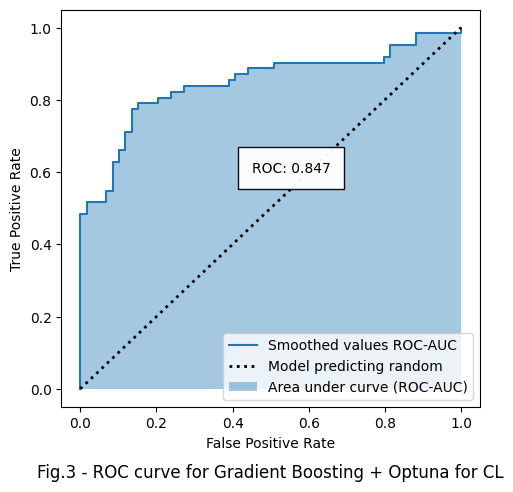

In [254]:
# Apply best parameters
gb_opt_cl = GradientBoostingClassifier(**best_hyperparameters.params, random_state=random_seed) #study.best_params
gb_opt_cl.fit(X_train, y_train)

# Predict target values
y_pred_gb_optu = gb_opt_cl.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb_optu))

get_ROC_plot(gb_opt_cl, X_test, y_test, 'Gradient Boosting + Optuna for CL', fig_id=3)

### Model Stacking classifier

              precision    recall  f1-score   support

         0.0       0.54      0.76      0.63        50
         1.0       0.68      0.44      0.54        59

    accuracy                           0.59       109
   macro avg       0.61      0.60      0.58       109
weighted avg       0.62      0.59      0.58       109

 MAE: 0.41

roc_auc:  0.635


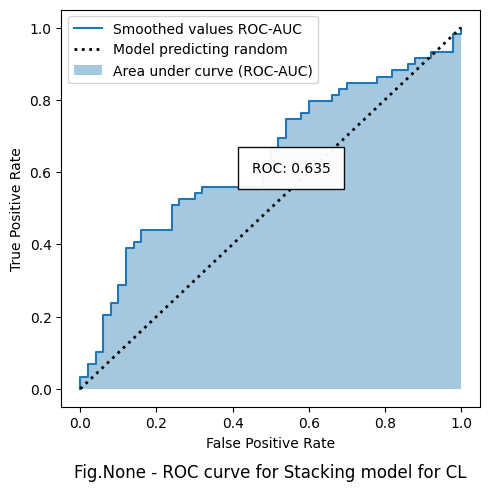

In [181]:
# Initiate estimators
estimators = [
    ('dt', DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=6,
        max_depth=2,
        random_state=random_seed
        )
    ),
    ('log_reg', LogisticRegression(
        solver='saga',
        random_state=random_seed 
        )
    ),
    ('gb', GradientBoostingClassifier(
        random_state=random_seed
        )
    )
]

# Stacking instance creation
stack_cl = StackingClassifier(
    estimators,
    final_estimator=LogisticRegression(random_state=random_seed) #GradientBoostingClassifier(random_state=random_seed)
)

# Training the model
stack_cl.fit(X_train, y_train)

# get the prediction
y_pred_st = stack_cl.predict(X_test)

print(classification_report(y_test, y_pred_st))

print('')

#get_ROC_plot(stack_cl, X_test, y_test, 'Stacking model for CL')

## 1.1.3 Model comparison for Credit loan classification

| Model | ROC AUC score | Weighted average <br> f1-score |
:- | :--: | :--:
| Logistic regression | 0.65 | 0.57|
| Decision tree | 0.49 | 0.61 |
| Random Forest | 0.82 | 0.73 |
| Gradient Boosting | 0.74 | 0.71 |
| Gradient Boosting + Optuna | <mark>0.9</mark> | 0.88 |
| Stacking model | 0.87 | 0.79 |

In [141]:
# Save model to the given path in the pkl format
model_name = 'gb_opt_cl'
models_dict = dict()

full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
models_dict.update({'Sales_CLoans':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gb_opt_cl, f)

### Feature importance

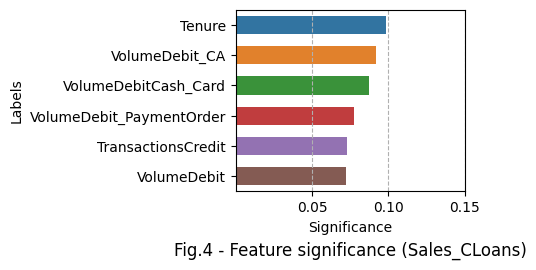

In [142]:
feature_importances_cl = pd.Series(gb_opt_cl.feature_importances_, index=X.columns).sort_values(ascending=False)
fig_id=4

fig, ax = plt.subplots(figsize=(5, 3))

hist = sns.barplot(
    x=feature_importances_cl[:6], 
    y=feature_importances_cl.index[:6], width=0.6
);

hist.set(xlabel='Significance', ylabel='Labels')
ax.set_title(f'Fig.{fig_id} - Feature significance (Sales_CLoans)', y=-0.4);
major_ticks = np.linspace(0.05, 0.15, 3)
ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout();

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

In [143]:
feature_importances_cl.round(2).head(7)*100

Tenure                      10.0
VolumeDebit_CA               9.0
VolumeDebitCash_Card         9.0
VolumeDebit_PaymentOrder     8.0
TransactionsCredit           7.0
VolumeDebit                  7.0
VolumeCredit                 6.0
dtype: float64

# 1.2 Consumer loan regression

## 1.2.1 Preparation

In [144]:
# separation of the target feature
X, y = data_scaled, targets['Revenue_CLoans'].values

In [145]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (684, 18)
Test shape:  (85, 18)
Valid shape: (86, 18)


## 1.2.2 Modelling

### Linear model

In [183]:
# Creation an instance
lin_cl = LinearRegression()

# Train the Model
lin_cl.fit(X_train, y_train)

# Predict target values
y_pred_lin = lin_cl.predict(X_test)

print(f'MSE {round(mean_squared_error(y_test, y_pred_lin),2)}')
print(f'MAE {round(mean_absolute_error(y_test, y_pred_lin),2)}')

MSE 0.26
MAE 0.5


### Random Forest

In [186]:
rfr_cl =  RandomForestRegressor(
    n_estimators=100, 
    verbose=0, n_jobs=-1,  
    random_state=random_seed)

# Model training
rfr_cl.fit(X_train, y_train)

# Predict target values
y_pred_rfr = rfr_cl.predict(X_test)

print(f'MSE {round(mean_squared_error(y_test, y_pred_rfr),2)}')
print(f'MAE {round(mean_absolute_error(y_test, y_pred_rfr),2)}')
#print(f'RMSE {round((mean_squared_error(y_test, y_pred_rfr)**0.5),2)}')

MSE 0.21
MAE 0.42


### Gradient boosting

In [191]:
gbr_cl = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=70,
    random_state=random_seed 
)
# Model training
gbr_cl.fit(X_train, y_train)

# Predict target values
y_pred_gbr = gbr_cl.predict(X_test)

print(f'MSE {round(mean_squared_error(y_test, y_pred_gbr),2)}')
print(f'MAE {round(mean_absolute_error(y_test, y_pred_gbr),2)}')
print(f'Median abs error {round(median_absolute_error(y_valid, y_pred_gbr),2)}')

MSE 0.25
MAE 0.48
Median abs error 0.49


#### Optuna

In [192]:
def optuna_gbr(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 40, 250, 1)
    max_depth = trial.suggest_int('max_depth', 2, 15, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.15)
    min_samples_leaf = trial.suggest_int('max_depth', 2, 15, 1)
   
    # model creation 
    model = GradientBoostingRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features='auto',
        min_samples_leaf = min_samples_leaf,
        learning_rate=learning_rate,
        random_state=random_seed
    )
    
    # training
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse_score = mean_squared_error(y_test, y_pred)

    return mse_score 

In [193]:
%%time
# create study set
study = optuna.create_study(study_name="GradientBoostingRegressor", direction="minimize", sampler=sampler)
# try multiple times
study.optimize(optuna_gbr, n_trials=30)

clear_output(wait=False)

optuna.visualization.plot_optimization_history(study, target_name="mean_squared_error")

CPU times: total: 45.4 s
Wall time: 45.4 s


In [194]:
gbr_opt_cl = GradientBoostingRegressor(
    **study.best_params,
    random_state=random_seed 
)
# Model training
gbr_opt_cl.fit(X_train, y_train)

# Predict target values
y_pred_gbr_opt = gbr_opt_cl.predict(X_test)

print(f'MSE {round(mean_squared_error(y_test, y_pred_gbr_opt),2)}')
print(f'MAE {round(mean_absolute_error(y_test, y_pred_gbr_opt),2)}')

MSE 0.43
MAE 0.48


### Model Stacking regressor

In [195]:
# Initiate estimators
estimators = [
    ('Rr', RidgeCV()),
    #('R', Ridge()),
    ('lr1', LinearRegression()),
    ('sgd', SGDRegressor(random_state=random_seed)),
    #('rfr', RandomForestRegressor(random_state=random_seed))
]

# Stacking instance creation
stack_rg_cl = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(
        n_estimators=150,
        random_state=random_seed)
)
# Model training
stack_rg_cl.fit(X_train, y_train)

# Prediction of target values
y_pred_st_stek_reg = stack_rg_cl.predict(X_test)

print(f'MSE {round(mean_squared_error(y_test, y_pred_st_stek_reg),2)}')
print(f'MAE {round(mean_absolute_error(y_test, y_pred_st_stek_reg),2)}')
#print(f'RMSE {round((mean_squared_error(y_valid, y_pred_st_stek_reg)**0.5),2)}')

MSE 0.3
MAE 0.49


## 1.2.3 Model comparison for Credit loan regression

| Model | MSE | MAE |
:- | :--: | :--: 
| Linear regression | 6.5 | 1.81 |
| Random Forest Regressor | 6.7 | 1.7 |
| Random Forest Regressor + optuna | 6.4 | 1.8 |
| Gradient Boosting Regressor | 29.58 | 4.5 |
| Gradient Boosting Regressor + Optuna | <mark>6.2</mark> | 1.7 |
| Stacking model | 7.4 | 1.7 |

In [196]:
# Save model to the given path in the pkl format
model_name = 'gbr_opt_cl'
full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
models_dict.update({'Revenue_CLoans':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gbr_opt_cl, f)

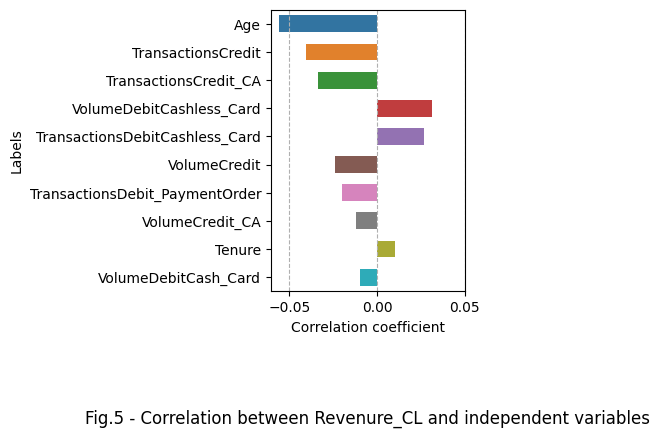

In [197]:
# correlation scores with the dependent variable
corr_df = data_scaled.corrwith(targets['Revenue_CLoans'], method='pearson')
corr_df = pd.DataFrame({'corr_value':corr_df})

corr_df.sort_values(by='corr_value', key=abs, ascending=False, inplace=True)#.round(2).to_dict()

fig_id=5
fig, ax = plt.subplots(figsize=(5, 5))
hist = sns.barplot(corr_df[:10], x='corr_value' , y=corr_df.index[:10], width=0.6);

hist.set(xlabel='Correlation coefficient', ylabel='Labels')
ax.set_title(f'Fig.{fig_id} - Correlation between Revenue_CL and independent variables', y=-0.5);
major_ticks = np.linspace(-0.05, 0.05, 3)
ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout()

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

## 1.2.4 Feature selection

In [ ]:
# selector = SelectKBest(f_regression, k=6)
# selector.fit(X_train, y_train)
 
# features_out_kbest = selector.get_feature_names_out().tolist()
# print('The most important features are: \n', features_out_kbest)

The most important features are: 
 ['Age', 'Tenure', 'VolumeCredit_CA', 'TransactionsCredit', 'TransactionsCredit_CA', 'TransactionsDebit']


In [ ]:
# def optuna_gbr(trial):
#     # set dimensions
#     n_estimators = trial.suggest_int('n_estimators', 40, 250, 1)
#     max_depth = trial.suggest_int('max_depth', 2, 8, 1)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.15)
   
#     # model creation 
#     model = GradientBoostingRegressor(
#         max_depth=max_depth,
#         n_estimators=n_estimators,
#         max_features='auto',
#         learning_rate=learning_rate,
#         random_state=random_seed
#     )
    
#     # training
#     model.fit(X_train[features_out_kbest], y_train)
    
#     y_pred = model.predict(X_valid[features_out_kbest])
#     mse_score = mean_squared_error(y_valid, y_pred)

#     return mse_score 

In [ ]:
# %%time
# # create study set
# study = optuna.create_study(study_name="GradientBoostingRegressor", direction="minimize", sampler=sampler)
# # try multiple times
# study.optimize(optuna_gbr, n_trials=70)

# clear_output(wait=False)

# optuna.visualization.plot_optimization_history(study, target_name="mean_squared_error")

CPU times: total: 12 s
Wall time: 12.1 s


In [ ]:
# gbr_opt_cl_lim = GradientBoostingRegressor(
#     **study.best_params,
#     random_state=random_seed 
# )
# # Model training
# gbr_opt_cl_lim.fit(X_train[features_out_kbest], y_train)

# # Predict target values
# y_pred_gbr_opt = gbr_opt_cl_lim.predict(X_valid[features_out_kbest])

# print(f'MSE {round(mean_squared_error(y_valid, y_pred_gbr_opt),2)}')
# print(f'MAE {round(mean_absolute_error(y_valid, y_pred_gbr_opt),2)}')

MSE 27.43
MAE 4.0


In [ ]:
# sort=gbr_opt_cl_lim.feature_importances_.argsort()[::-1]

# fig, ax = plt.subplots(figsize=(5, 4))

# hist = sns.barplot(
#     x=gbr_opt_cl_lim.feature_importances_[sort][:8], 
#     y=gbr_opt_cl_lim.feature_names_in_[sort][:8], width=0.6
# );

# hist.set(xlabel='Significance', ylabel='Labels')
# ax.set_title(f'Fig.{fig_id} - Feature significance (Sales_CLoans)', y=-0.4);
# #major_ticks = np.linspace(0.05, 0.15, 3)
# #ax.set_xticks(major_ticks)
# ax.xaxis.grid(linestyle='--')
# plt.tight_layout();

# #plt.savefig(f'figures/fig_{fig_id}.png')

# 2.1 Credit card classification

## 2.1.1 Preparation

### Target variable

0.0    0.64
1.0    0.36
Name: Sales_CCards, dtype: float64


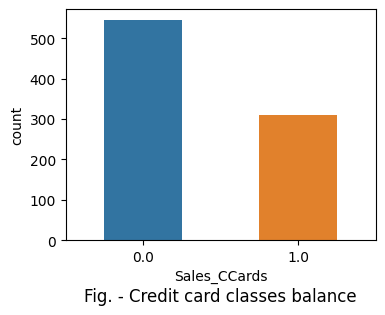

In [204]:
fig, ax = plt.subplots(figsize=(4, 3)) 
sns.countplot(data=targets, x='Sales_CCards', width=0.5)
ax.set_title('Fig. - Credit card classes balance', y=-0.3);

#plt.savefig('../figures/fig_2.png')

print(targets['Sales_CCards'].value_counts(True).round(2))

In [205]:
# separation of the target feature
X, y  = data_scaled, targets['Sales_CCards'].values

In [206]:
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0. 1.] [545 310]


### Balancing samples

In [207]:
# Synthetic resampling of minority class
sm = SMOTE(random_state=random_seed)
X, y = sm.fit_resample(X, y)

unique, counts = np.unique(y, return_counts=True)
print('After ynthetic resampling : ',unique, counts)

After ynthetic resampling :  [0. 1.] [545 545]


In [208]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (872, 18)
Test shape:  (109, 18)
Valid shape: (109, 18)


## 2.1.2 Modelling

### Log regression

              precision    recall  f1-score   support

         0.0       0.48      0.60      0.54        50
         1.0       0.57      0.46      0.51        59

    accuracy                           0.52       109
   macro avg       0.53      0.53      0.52       109
weighted avg       0.53      0.52      0.52       109

MSE: 0.48

roc_auc:  0.49


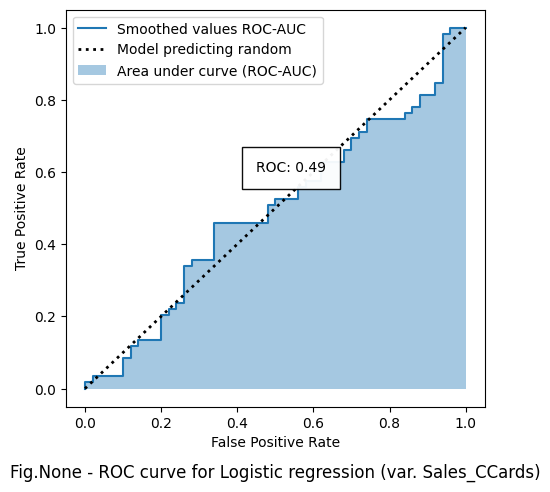

In [209]:
log_reg_cc = LogisticRegression(
    solver='sag', 
    max_iter=1000,
    C = 0.1,
    random_state=random_seed)

# Model training
log_reg_cc.fit(X_train, y_train) 

# Prediction of target values
y_pred_log = log_reg_cc.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_log))

print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_log)))
print("")

get_ROC_plot(log_reg_cc, X_test, y_test, 'Logistic regression (var. Sales_CCards)')

#### Decision tree

              precision    recall  f1-score   support

         0.0       0.52      0.74      0.61        50
         1.0       0.66      0.42      0.52        59

    accuracy                           0.57       109
   macro avg       0.59      0.58      0.56       109
weighted avg       0.60      0.57      0.56       109

MSE: 0.43

roc_auc:  0.621


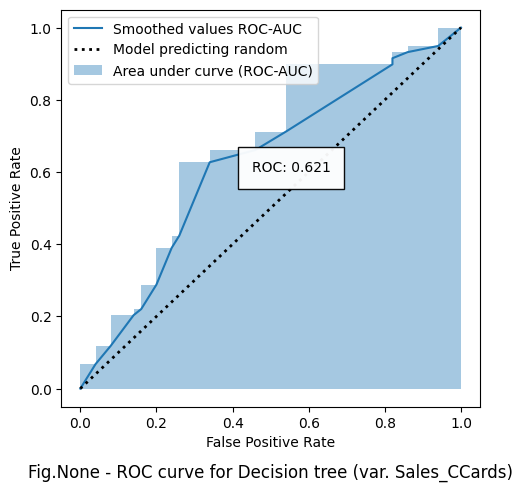

In [210]:
# Model creation
dt_cc = DecisionTreeClassifier(
    criterion='entropy',  
    max_depth=6,  
    min_samples_leaf=4,  
    random_state=random_seed, 
)
# Model training
dt_cc.fit(X_train, y_train)
# Prediction of target values
y_pred_dt = dt_cc.predict(X_test)

# Metrics report    
print(classification_report(y_test, y_pred_dt))

print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_dt)))
print("")

get_ROC_plot(dt_cc, X_test, y_test, 'Decision tree (var. Sales_CCards)')

### Random Forest

              precision    recall  f1-score   support

         0.0       0.57      0.70      0.63        50
         1.0       0.69      0.56      0.62        59

    accuracy                           0.62       109
   macro avg       0.63      0.63      0.62       109
weighted avg       0.64      0.62      0.62       109

MSE: 0.38

roc_auc:  0.6


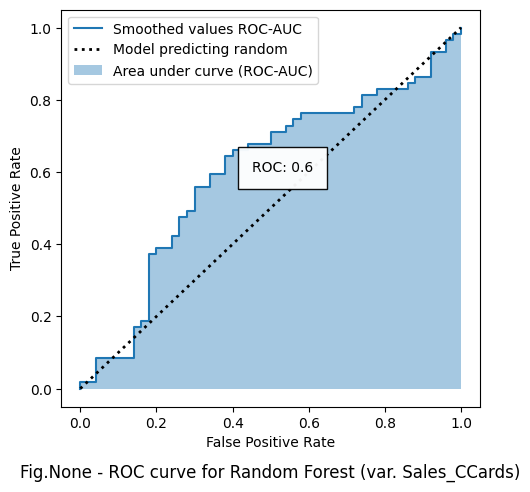

In [211]:
rf_cc = RandomForestClassifier(
    n_estimators=100, 
    min_samples_leaf=3,
    max_depth=5,
    #verbose=1, 
    n_jobs=-1, 
    random_state=random_seed)

#Train model
rf_cc.fit(X_train, y_train)

# Prediction
y_pred_rf = rf_cc.predict(X_test)

print(classification_report(y_test, y_pred_rf))

print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_rf)))
print('')

get_ROC_plot(rf_cc, X_test, y_test, 'Random Forest (var. Sales_CCards)')

### Gradient boosting

              precision    recall  f1-score   support

         0.0       0.61      0.78      0.68        50
         1.0       0.76      0.58      0.65        59

    accuracy                           0.67       109
   macro avg       0.68      0.68      0.67       109
weighted avg       0.69      0.67      0.67       109

MSE: 0.33

roc_auc:  0.712


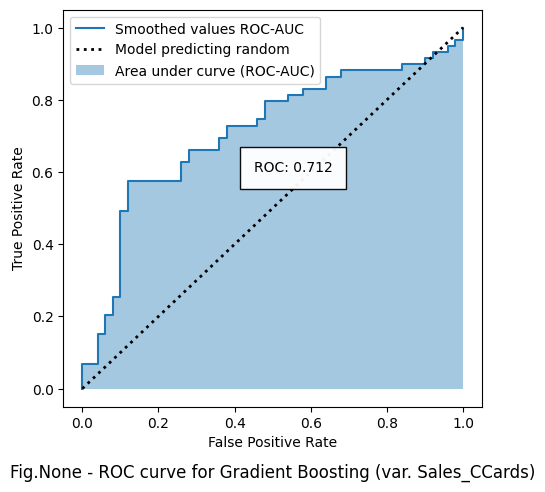

In [212]:
gb_cc = GradientBoostingClassifier(
    learning_rate=0.07,
    n_estimators=105,
    min_samples_leaf=2,
    max_depth=4,
    random_state=random_seed
)

# train model
gb_cc.fit(X_train, y_train)
 
# Predict target values
y_pred_gb = gb_cc.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb))

print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_gb)))
print("")

get_ROC_plot(gb_cc, X_test, y_test, 'Gradient Boosting (var. Sales_CCards)')

### Gradient Boosting + Optuna

In [213]:
def optuna_gb(trial):
    """
    Hyperparameters optimization for gradient boosting classifier model

    Args:
        trial (_type_): iteration

    Returns:
        F1_score, roc_score
    """
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 150, 300, 1)
    max_depth = trial.suggest_int('max_depth', 5, 20, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.25)
    
    # model creation 
    model = GradientBoostingClassifier(
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=random_seed)
    
    # training
    model.fit(X_train, y_train)
    y_pred = np.round(model.predict_proba(X_test)[:,1])
    F1_score = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred)
    
    return F1_score, roc_score

In [214]:
%%time
# create study set
study = optuna.create_study(study_name="GradientBoostingClassifier", directions=["maximize", "maximize"], sampler=sampler)
# try multiple times
study.optimize(optuna_gb, n_trials=40)
clear_output(wait=False)

optuna.visualization.plot_pareto_front(study, target_names=["F1_score", "roc_score"])

CPU times: total: 1min 31s
Wall time: 1min 32s


In [215]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

best_hyperparameters = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {best_hyperparameters.number}")
print(f"\tparams: {best_hyperparameters.params}")
#print(f"\tvalues: {best_hyperparameters.values}")

Number of trials on the Pareto front: 4
Trial with highest accuracy: 
	params: {'n_estimators': 247, 'max_depth': 5, 'min_samples_leaf': 13, 'learning_rate': 0.1787495380260124}


              precision    recall  f1-score   support

         0.0       0.67      0.84      0.74        50
         1.0       0.83      0.64      0.72        59

    accuracy                           0.73       109
   macro avg       0.75      0.74      0.73       109
weighted avg       0.75      0.73      0.73       109

MSE: 0.27

roc_auc:  0.755


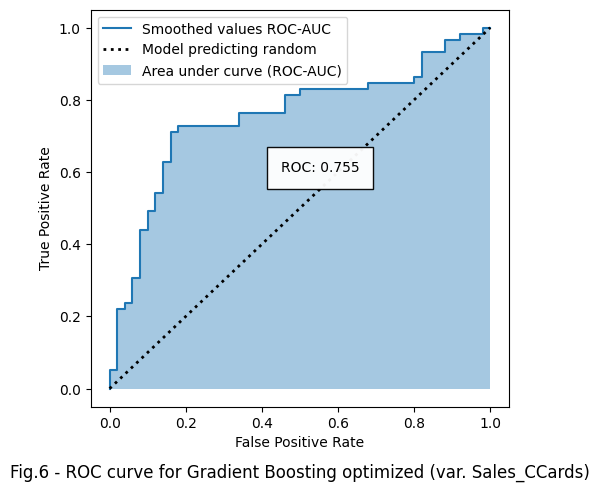

In [216]:
# Apply best parameters
gb_opt_cc = GradientBoostingClassifier(**best_hyperparameters.params,random_state=random_seed)
gb_opt_cc.fit(X_train, y_train)

# Predict target values
y_pred_gb_opt = gb_opt_cc.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb_opt))
print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_gb_opt)))
print("")

get_ROC_plot(gb_opt_cc, X_test, y_test, 'Gradient Boosting optimized (var. Sales_CCards)', fig_id=6)

### Model Stacking classifier

              precision    recall  f1-score   support

         0.0       0.59      0.78      0.67        50
         1.0       0.74      0.54      0.63        59

    accuracy                           0.65       109
   macro avg       0.67      0.66      0.65       109
weighted avg       0.67      0.65      0.65       109

MSE: 0.35

roc_auc:  0.688


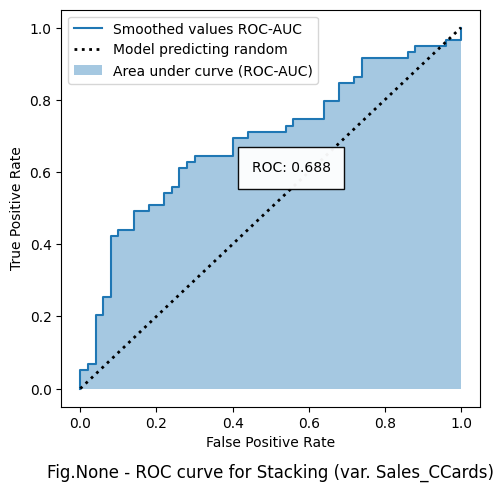

In [217]:
# Initiate estimators
estimators = [
    ('dt', DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=3,
        max_depth=4,
        random_state=random_seed
        )
    ),
    ('log_reg', LogisticRegression(
        solver='sag',
        random_state=random_seed 
        )
    ),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=140,
        min_samples_leaf=4,
        max_depth=4,
        random_state=random_seed
        )
    )
]

# Stacking instance creation
stack_cl_cc = StackingClassifier(
    estimators,
    final_estimator=LogisticRegression(random_state=random_seed)
)

# Training the model
stack_cl_cc.fit(X_train, y_train)

# get the prediction
y_pred_st_cc =  stack_cl_cc.predict(X_test)

print(classification_report(y_test, y_pred_st_cc))
print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_st_cc)))
print("")


get_ROC_plot(stack_cl_cc, X_test, y_test, 'Stacking (var. Sales_CCards)')

## 2.1.3 Models metric comparisson

| Model | ROC AUC score |  Weighted average <br> f1-score |
:- | :--:| :--:
| Logistic regression | 0.68 | 0.64 |
| Decision tree | 0.72 | 0.64 |
| Random Forest | 0.73 | 0.67 |
| Gradient Boosting | 0.81 | 0.72 |
| Gradient Boosting Optuna | <mark>0.87</mark> | 0.82 |
| Stacking model | 0.82 | 0.78 |

In [218]:
# Save model to the given path in the pkl format
model_name = 'gb_opt_cc'

full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
models_dict.update({'Sales_CCards':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gb_opt_cc, f)

## Feature importance

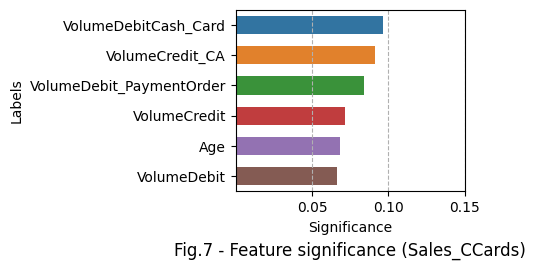

In [221]:
feature_importances_cc = pd.Series(gb_opt_cc.feature_importances_, index=X.columns).sort_values(ascending=False)
fig_id = 7
fig, ax = plt.subplots(figsize=(5, 3))

hist = sns.barplot(
    x=feature_importances_cc[:6], 
    y=feature_importances_cc.index[:6], width=0.6
);

hist.set(xlabel='Significance', ylabel='Labels')
ax.set_title(f'Fig.{fig_id} - Feature significance (Sales_CCards)', y=-0.4);

major_ticks = np.linspace(0.05, 0.15, 3)
ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout();

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

# 2.2 Credit card regression

## 2.2.1 Preparation

In [227]:
# separation of the target feature
X, y  = data_scaled, targets['Revenue_CCards'].values

In [228]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (684, 18)
Test shape:  (85, 18)
Valid shape: (86, 18)


## 2.2.2 Modelling

#### Linear model

In [231]:
# Creation an instance
lin_cc = LinearRegression()

# Train the Model
lin_cc.fit(X_train, y_train)
 
# Predict target values
y_pred_lin = lin_cc.predict(X_test)

print('MSE: {:.4}'.format(mean_squared_error(y_test, y_pred_lin)))
print('MAE: {:.4}'.format(mean_absolute_error(y_test, y_pred_lin)))

MSE: 153.9
MAE: 10.75


### Random Forest

In [232]:
rfr_cc =  RandomForestRegressor(
    n_estimators=150, 
    max_depth=3,
    verbose=0, n_jobs=-1,  
    random_state=random_seed)

# Model training
rfr_cc.fit(X_train, y_train)

# Predict target values
y_pred_rfr_cc = rfr_cc.predict(X_test)

print('MSE: {:.4}'.format(mean_squared_error(y_test, y_pred_rfr_cc)))
print('MAE: {:.4}'.format(mean_absolute_error(y_test, y_pred_rfr_cc)))

MSE: 164.9
MAE: 11.45


### Gradient boosting

In [234]:
gbr_cc = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=50,
    random_state=random_seed 
)
# Model training
gbr_cc.fit(X_train, y_train)

# Predict target values
y_pred_gbr_cc = gbr_cc.predict(X_test)

print('MSE: {:.4}'.format(mean_squared_error(y_test, y_pred_gbr_cc)))
print('MAE: {:.4}'.format(mean_absolute_error(y_test, y_pred_gbr_cc)))
#print(f'RMSE {round((mean_squared_error(y_valid, y_pred_gbr_cc)**0.5),2)}')

MSE: 165.3
MAE: 11.09


### Gradient boosting + optuna

In [235]:
def optuna_gbr(trial):
    """
    Hyperparameters optimization for gradient boosting regressor model

    Args:
      trial (_type_): iteration

    Returns:
      F1_score
    """
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 10, 200, 1)
    max_depth = trial.suggest_int('max_depth', 2, 10, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 8 , 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.15)
    #loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])    
    
    # model creation 
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion="squared_error",
        max_features='auto',
        learning_rate=learning_rate,
        random_state=random_seed
    )
    
    # training
    model.fit(X_train, y_train)
    
    score = mean_squared_error(y_test, model.predict(X_test))

    return score 

In [237]:
%%time
# create study set
study = optuna.create_study(study_name="GradientBoostingRegressor_cc", direction="minimize", sampler=sampler)

# try multiple times
study.optimize(optuna_gbr, n_trials=25)
clear_output(wait=False)

optuna.visualization.plot_optimization_history(study, target_name="mean_squared_error")

CPU times: total: 10.2 s
Wall time: 10.2 s


In [239]:
gbr_cc_opt = GradientBoostingRegressor(
    **study.best_params,
    random_state=random_seed 
)
# Model training
gbr_cc_opt.fit(X_train, y_train)

# Predict target values
y_pred_gbr = gbr_cc_opt.predict(X_test)

print('MSE: {:.4}'.format(mean_squared_error(y_test, y_pred_gbr)))
print('MAE: {:.4}'.format(mean_absolute_error(y_test, y_pred_gbr)))
#print(f'RMSE {round((mean_squared_error(y_valid,y_pred_gbr)**0.5),2)}')

MSE: 156.1
MAE: 10.8


### Model Stacking regressor

In [240]:
# Initiate estimators
estimators = [
    #('Rr', RidgeCV()),
    ('R', Ridge()),
    ('lr1',  LinearRegression()),
    ('sgd', SGDRegressor(random_state=random_seed)),
    #('rfr', RandomForestRegressor(random_state=random_seed))
]

# Stacking instance creation
stack_rg_cc = StackingRegressor(
    estimators=estimators,
    final_estimator=SGDRegressor(
        #n_estimators=80,
        random_state=random_seed)
)
# Model training
stack_rg_cc.fit(X_train, y_train)

# Prediction of target values
y_pred_st_stek_reg = stack_rg_cc.predict(X_test)

print('MSE: {:.4}'.format(mean_squared_error(y_test, y_pred_st_stek_reg)))
print('MAE: {:.4}'.format(mean_absolute_error(y_test, y_pred_st_stek_reg)))
#print(f'RMSE {round((mean_squared_error(y_valid, y_pred_st_stek_reg)**0.5),2)}')

MSE: 247.3
MAE: 10.47


## 2.2.3 Models metric 


| Model | MSE | MAE |
:- | :--: | :--: 
| Linear regression | 9.9 | 2.1 |
| Random Forest Regressor | 9.8 | 2.1 |
| Random Forest Regressor + optuna | 9.8 | 2.2 |
| Gradient Boosting Regressor | 11.4 | 2.3 |
| Gradient Boosting Regressor + Optuna | <mark>9.5</mark> | 2.1 |
| Stacking model | 10.2 | 2.1 |

In [241]:
# Save model to the given path in the pkl format
model_name = 'gbr_cc_opt'
full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
models_dict.update({'Revenue_CCards':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gbr_cc_opt, f)

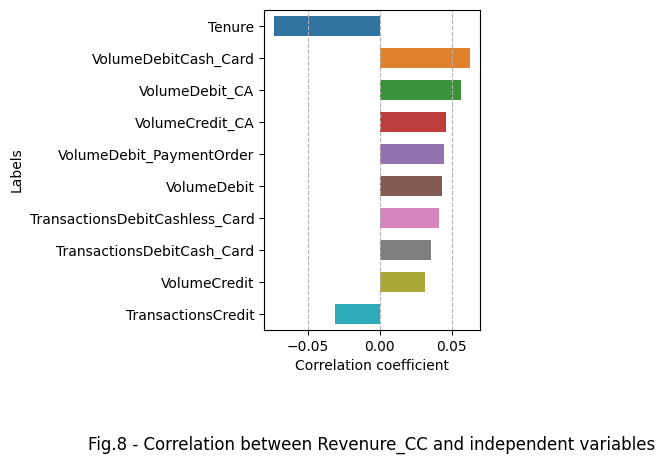

In [242]:
# correlation scores with the dependent variable
corr_df = data_scaled.corrwith(targets['Revenue_CCards'], method='pearson')
corr_df = pd.DataFrame({'corr_value':corr_df})

corr_df.sort_values(by='corr_value', key=abs, ascending=False, inplace=True)#.round(2).to_dict()

fig_id=8
fig, ax = plt.subplots(figsize=(5, 5))
hist = sns.barplot(corr_df[:10], x='corr_value' , y=corr_df.index[:10],width=0.6);

hist.set(xlabel='Correlation coefficient', ylabel='Labels')
ax.set_title(f'Fig.{fig_id} - Correlation between Revenure_CC and independent variables', y=-0.4);
major_ticks = np.linspace(-0.05, 0.05, 3)
ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout();

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

# 3.1 Mutal fund classification

## 3.1.1 Preparation

### Target variable

0.0    0.71
1.0    0.29
Name: Sales_MFunds, dtype: float64


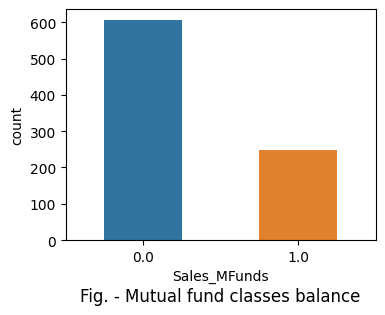

In [243]:
fig, ax = plt.subplots(figsize=(4, 3)) 
sns.countplot(data=targets, x='Sales_MFunds', width=0.5)
ax.set_title('Fig. - Mutual fund classes balance', y=-0.3);

#plt.savefig('../figures/fig_2.png')

print(targets['Sales_MFunds'].value_counts(True).round(2))

In [244]:
# separation of the target feature
X, y  = data_scaled , targets['Sales_MFunds'].values

In [245]:
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0. 1.] [606 249]


### Balancing samples

In [246]:
# Synthetic resampling of minority class
sm = SMOTE(random_state=random_seed)
X, y = sm.fit_resample(X, y)

unique, counts = np.unique(y, return_counts=True)
print('After ynthetic resampling : ',unique, counts)

After ynthetic resampling :  [0. 1.] [606 606]


In [247]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (969, 18)
Test shape:  (121, 18)
Valid shape: (122, 18)


## 3.1.2 Modelling

### Log regression

              precision    recall  f1-score   support

         0.0       0.55      0.47      0.51        59
         1.0       0.56      0.63      0.59        62

    accuracy                           0.55       121
   macro avg       0.55      0.55      0.55       121
weighted avg       0.55      0.55      0.55       121

MSE: 0.45

roc_auc:  0.589


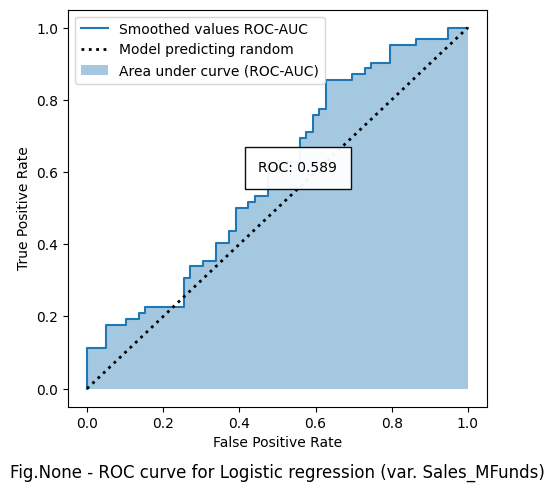

In [248]:
log_reg_mf = LogisticRegression(
    solver='sag', 
    max_iter=2000,
    C = 0.1,
    random_state=random_seed)

# Model training
log_reg_mf.fit(X_train, y_train) 

# Prediction of target values
y_pred_mf =  log_reg_mf.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_mf))

print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_mf)))
print("")

get_ROC_plot(log_reg_mf, X_test, y_test, 'Logistic regression (var. Sales_MFunds)')

#### Decision tree

              precision    recall  f1-score   support

         0.0       0.61      0.56      0.58        59
         1.0       0.61      0.66      0.64        62

    accuracy                           0.61       121
   macro avg       0.61      0.61      0.61       121
weighted avg       0.61      0.61      0.61       121

MSE: 0.39

roc_auc:  0.658


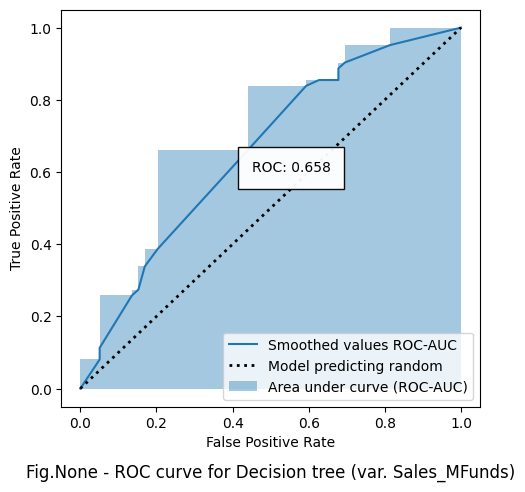

In [255]:
# Model creation
dt_mf = DecisionTreeClassifier(
    criterion='entropy',  
    max_depth=5,  
    min_samples_leaf=2,  
    random_state=random_seed, 
)
# Model training
dt_mf.fit(X_train, y_train)
# Prediction of target values
y_pred_dt = dt_mf.predict(X_test)

# Metrics report    
print(classification_report(y_test, y_pred_dt))

print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_dt)))
#print(' MAPE: {:.2}'.format(mean_absolute_percentage_error(y_valid, y_pred_dt)*100))
print("")

get_ROC_plot(dt_mf, X_test, y_test, 'Decision tree (var. Sales_MFunds)')

### Random Forest

              precision    recall  f1-score   support

         0.0       0.65      0.61      0.63        59
         1.0       0.65      0.69      0.67        62

    accuracy                           0.65       121
   macro avg       0.65      0.65      0.65       121
weighted avg       0.65      0.65      0.65       121

 MSE: 0.35

roc_auc:  0.704


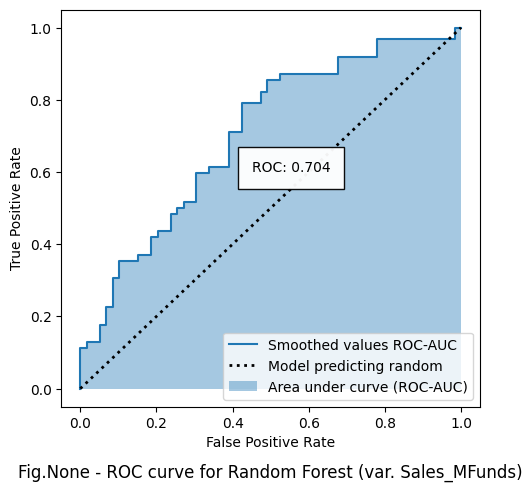

In [256]:
rf_mf = RandomForestClassifier(
    n_estimators=150, 
    min_samples_leaf=5,
    max_depth=4,
    #max_samples = 0.8,
    #verbose=1, 
    n_jobs=-1, 
    random_state=random_seed)

#Train model
rf_mf.fit(X_train, y_train)

# Prediction
y_pred_rf = rf_mf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

print(' MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_rf)))
#print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_rf)*100, 2)} %")
print("")

get_ROC_plot(rf_mf,  X_test, y_test, 'Random Forest (var. Sales_MFunds)')

### Gradient boosting

              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78        59
         1.0       0.82      0.73      0.77        62

    accuracy                           0.78       121
   macro avg       0.78      0.78      0.78       121
weighted avg       0.78      0.78      0.78       121

MSE: 0.22

roc_auc:  0.849


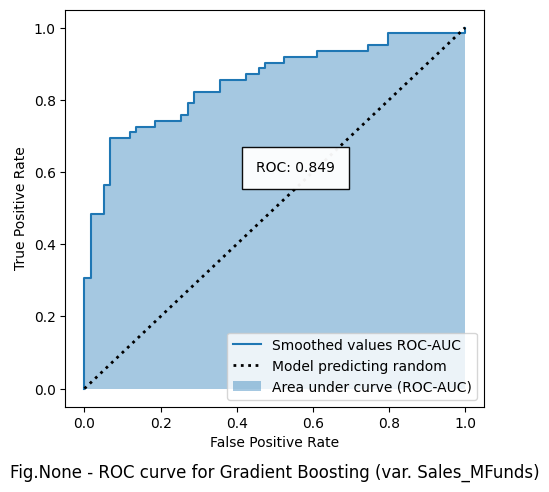

In [257]:
gb_mf = GradientBoostingClassifier(
    learning_rate=0.2,
    n_estimators=120,
    min_samples_leaf=7,
    max_depth=6,
    random_state=random_seed
)

# train model
gb_mf.fit(X_train, y_train)
 
# Predict target values
y_pred_gb = gb_mf.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb))

print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_gb)))
print("")

get_ROC_plot(gb_mf, X_test, y_test, 'Gradient Boosting (var. Sales_MFunds)')

### Gradient Boosting + Optuna

In [259]:
def optuna_gb(trial):
    """
    Hyperparameters optimization for gradient boosting classifier model

    Args:
        trial (_type_): iteration

    Returns:
        F1_score, roc_score
    """
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 50, 300, 1)
    max_depth = trial.suggest_int('max_depth', 2, 15, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    
    # model creation 
    model = GradientBoostingClassifier(
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=random_seed)
    
    # training
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)[:,1]
    F1_score = f1_score(y_test, model.predict(X_test))
    roc_score = roc_auc_score(y_test, model.predict(X_test))
    
    return F1_score, roc_score

In [260]:
%%time
# create study set
study = optuna.create_study(study_name="GradientBoostingClassifier", directions=["maximize", "maximize"], sampler=sampler)
# try multiple times
study.optimize(optuna_gb, n_trials=30)
clear_output(wait=False)

optuna.visualization.plot_pareto_front(study, target_names=["F1_score", "roc_score"])

CPU times: total: 44.2 s
Wall time: 44.3 s


In [261]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

best_hyperparameters = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
print(f"\tnumber: {best_hyperparameters.number}")
print(f"\tparams: {best_hyperparameters.params}")
print(f"\tvalues: {best_hyperparameters.values}")

Number of trials on the Pareto front: 2
Trial with highest accuracy: 
	number: 24
	params: {'n_estimators': 206, 'max_depth': 5, 'min_samples_leaf': 8, 'learning_rate': 0.18100792172492863}
	values: [0.8173913043478261, 0.8281848004373975]


              precision    recall  f1-score   support

         0.0       0.78      0.90      0.83        59
         1.0       0.89      0.76      0.82        62

    accuracy                           0.83       121
   macro avg       0.83      0.83      0.83       121
weighted avg       0.83      0.83      0.83       121

MSE: 0.17
MAPE: 2.2331898978696684e+16 %

roc_auc:  0.88


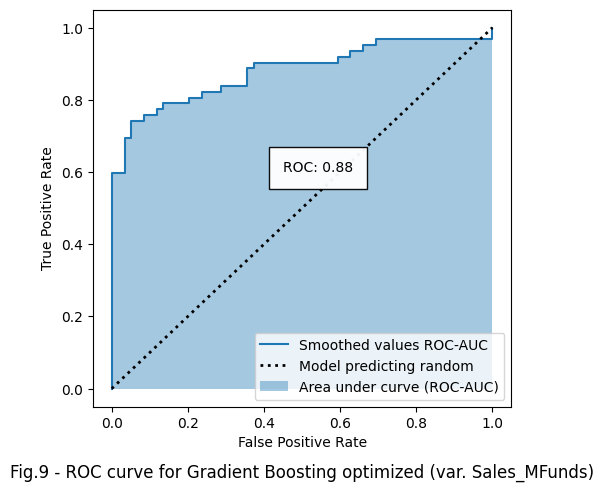

In [263]:
# Apply best parameters
gb_opt_mf = GradientBoostingClassifier(**best_hyperparameters.params, random_state=random_seed)
gb_opt_mf.fit(X_train, y_train)

# Predict target values
y_pred_gb_opt =  gb_opt_mf.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb_opt))

print('MSE: {:.2}'.format(mean_squared_error(y_test, y_pred_gb_opt)))
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_gb_opt)*100, 2)} %")
print("")

get_ROC_plot(gb_opt_mf,  X_test, y_test, 'Gradient Boosting optimized (var. Sales_MFunds)', fig_id=9)

### Model Stacking classifier

              precision    recall  f1-score   support

         0.0       0.71      0.85      0.78        59
         1.0       0.82      0.68      0.74        62

    accuracy                           0.76       121
   macro avg       0.77      0.76      0.76       121
weighted avg       0.77      0.76      0.76       121

 MAE: 0.24
MAPE: 3.3497848468045024e+16 %

roc_auc:  0.838


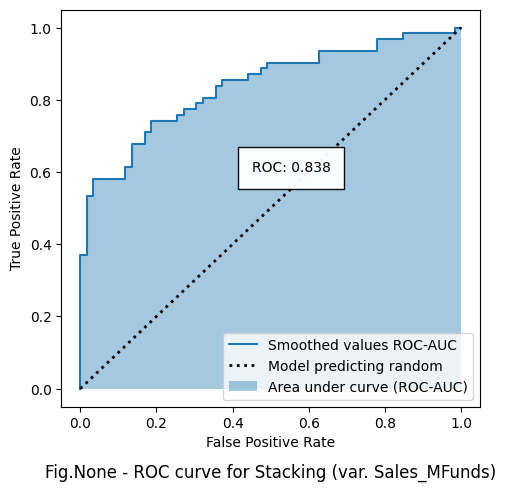

In [264]:
# Initiate estimators
estimators = [
    ('dt', DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=3,
        max_depth=4,
        random_state=random_seed
        )
    ),
    ('log_reg', LogisticRegression(
        solver='sag',
        random_state=random_seed 
        )
    ),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.2,
        n_estimators=180,
        min_samples_leaf=2,
        max_depth=4,
        random_state=random_seed
        )
    )
]

# Stacking instance creation
stack_cl_mf = StackingClassifier(
    estimators,
    final_estimator=LogisticRegression(random_state=random_seed)
)

# Training the model
stack_cl_mf.fit(X_train, y_train)

# get the prediction
y_pred_st = stack_cl_mf.predict(X_test)

print(classification_report(y_test, y_pred_st))


print(' MAE: {:.2}'.format(mean_absolute_error(y_test, y_pred_st)))
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_st)*100, 2)} %")
print("")

get_ROC_plot(stack_cl_mf,  X_test, y_test, 'Stacking (var. Sales_MFunds)')

## 3.1.3 Models metric comparisson

| Model | ROC AUC score | Weighted average <br> f1-score |
:- | :--: | :--:
| Logistic regression | 0.73 | 0.64 |
| Decision tree | 0.78 | 0.71 |
| Random Forest | 0.88 | 0.8 |
| Gradient Boosting | 0.92 | 0.85 |
| Gradient Boosting Optuna | <mark>0.95</mark> | 0.9|
| Stacking model | 0.92 | 0.83|

In [265]:
# Save model to the given path in the pkl format
model_name = 'gb_opt_mf'
full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
models_dict.update({'Sales_MFunds':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gb_opt_mf, f)

## Feature importance

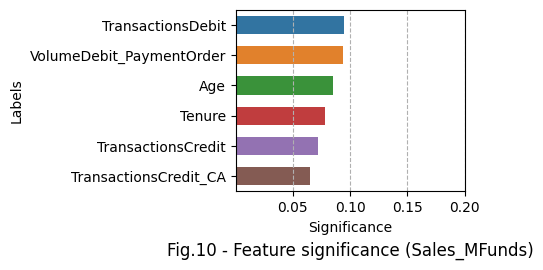

In [266]:
feature_importances_mf = pd.Series(gb_opt_mf.feature_importances_, index=X.columns).sort_values(ascending=False)
fig_id = 10

fig, ax = plt.subplots(figsize=(5, 3))

hist = sns.barplot(
    x=feature_importances_mf[:6], 
    y=feature_importances_mf.index[:6], width=0.6
);

hist.set(xlabel='Significance', ylabel='Labels')
ax.set_title(f'Fig.{fig_id} - Feature significance (Sales_MFunds)', y=-0.4)
major_ticks = np.linspace(0.05, 0.2, 4)
ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout();

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

# 3.2 Mutual fund regression

## 3.2.1 Preparation

In [267]:
# separation of the target feature
X, y  = data_scaled, targets['Revenue_MFunds'].values

In [268]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (684, 18)
Test shape:  (60, 18)
Valid shape: (61, 18)


## 3.2.1 Modelling

#### Linear model

In [270]:
# Creation an instance
lin_mf = LinearRegression()

# Train the Model
lin_mf.fit(X_train, y_train)
 
# Predict target values
y_pred_lin = lin_mf.predict(X_test)

print('MSE: {:.3}'.format(mean_squared_error(y_test, y_pred_lin)))
print('MAE: {:.2}'.format(mean_absolute_error(y_test, y_pred_lin)))

MSE: 15.9
MAE: 3.9


### Random Forest

In [272]:
rfr_mf =  RandomForestRegressor(
    n_estimators=200, 
    max_depth=2,
    verbose=0, n_jobs=-1,  
    random_state=random_seed)

# Model training
rfr_mf.fit(X_train, y_train)

# Predict target values
y_pred_rfr = rfr_mf.predict(X_test)

print('MSE: {:.3}'.format(mean_squared_error(y_test, y_pred_rfr)))
print('MAE: {:.2}'.format(mean_absolute_error(y_test, y_pred_rfr)))

MSE: 18.3
MAE: 4.1


### Random forest + optuna

In [273]:
def optuna_rfr(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 20, 100, 5)
    max_depth = trial.suggest_int('max_depth', 2, 6, 1)
    #min_samples_split = trial.suggest_int('min_samples_split', 2,4,1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 4 , 1)
    criterion = trial.suggest_categorical('criterion', ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    
    # model creation 
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        #min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf, 
        criterion = criterion,
        random_state=random_seed
    )
    
    # training
    model.fit(X_train, y_train)
    
    score = mean_squared_error(y_test, model.predict(X_test))

    return score 

In [274]:
%%time
# create study set
study = optuna.create_study(study_name="RandomForestRegressor_MF", direction="minimize", sampler=sampler)
# try multiple times
study.optimize(optuna_rfr, n_trials=30)
clear_output(wait=False)

optuna.visualization.plot_optimization_history(study, target_name="MSE_score")

CPU times: total: 10 s
Wall time: 10 s


In [275]:
# Apply best parameters
rfr_mf_opt = RandomForestRegressor(
    **study.best_params,
    random_state=random_seed
)
rfr_mf_opt.fit(X_train, y_train)

# Predict target values
y_pred_rfr_opt = rfr_mf_opt.predict(X_test)

print('MSE: {:.3}'.format(mean_squared_error(y_test, y_pred_rfr_opt)))
print('MAE: {:.2}'.format(mean_absolute_error(y_test, y_pred_rfr_opt)))

MSE: 2.97
MAE: 0.68


### Gradient boosting

In [276]:
gbr_mf = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=180,
    min_samples_leaf=7,
    random_state=random_seed 
)
# Model training
gbr_mf.fit(X_train, y_train)

# Predict target values
y_pred_gbr = gbr_mf.predict(X_test)

print('MSE: {:.3}'.format(mean_squared_error(y_test, y_pred_gbr)))
print('MAE: {:.2}'.format(mean_absolute_error(y_test, y_pred_gbr)))

MSE: 30.8
MAE: 4.7


#### Gradient boosting + Optuna

In [277]:
def optuna_gbr(trial):
    """
    Hyperparameters optimization for gradient boosting regressor model

    Args:
        trial (_type_): iteration

    Returns:
        F1_score
      """
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 100, 250, 1)
    max_depth = trial.suggest_int('max_depth', 2, 12, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 12 , 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.25)
   
    # model creation 
    model = GradientBoostingRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        criterion="squared_error",
        max_features='auto',
        learning_rate=learning_rate,
        random_state=random_seed
    )
    
    # training
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse_score = mean_squared_error(y_test, y_pred)
    
    return mse_score

In [278]:
%%time
# create study set
study = optuna.create_study(study_name="GradientBoostingRegressor", direction="minimize", sampler=sampler)
# try multiple times
study.optimize(optuna_gbr, n_trials=25)
clear_output(wait=False)

optuna.visualization.plot_optimization_history(study, target_name="mean_squared_error")

CPU times: total: 20 s
Wall time: 20 s


In [279]:
study.best_params

{'n_estimators': 101,
 'max_depth': 6,
 'min_samples_leaf': 12,
 'learning_rate': 0.010169183577908516}

In [280]:
gbr_opt_mf = GradientBoostingRegressor(
    **study.best_params,
    random_state=random_seed 
)
# Model training
gbr_opt_mf.fit(X_train, y_train)

# Predict target values
y_pred_gbr_opt = gbr_opt_mf.predict(X_test)

print('MSE: {:.3}'.format(mean_squared_error(y_test, y_pred_gbr_opt)))
print('MAE: {:.2}'.format(mean_absolute_error(y_test, y_pred_gbr_opt)))

MSE: 19.9
MAE: 4.2


### Model Stacking regressor

In [282]:
# Initiate estimators
estimators = [
    ('Rr', RidgeCV()),
    #('R', Ridge()),
    ('lr1',  LinearRegression()),
    ('sgd', SGDRegressor(random_state=random_seed)),
    #('rfr', RandomForestRegressor(random_state=random_seed))
]

# Stacking instance creation
stack_rg_mf = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(
        n_estimators=60, 
        max_depth=3,
        random_state=random_seed)
)
# Model training
stack_rg_mf.fit(X_train, y_train)

# Prediction of target values
y_pred_st_stek_reg = stack_rg_mf.predict(X_test)

print('MSE: {:.3}'.format(mean_squared_error(y_test, y_pred_st_stek_reg)))
print('MAE: {:.2}'.format(mean_absolute_error(y_test, y_pred_st_stek_reg)))

MSE: 14.7
MAE: 3.7


In [283]:
def optuna_st(trial):
    """
  Hyperparameters optimization for gradient boosting regressor model

  Args:
      trial (_type_): iteration

  Returns:
      F1_score
      """
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 40, 150, 1)
    max_depth = trial.suggest_int('max_depth', 2, 12, 1)
    
    estimators = [
    ('Rr', RidgeCV()),
    ('lr1',  LinearRegression()),
    ('sgd', SGDRegressor(random_state=random_seed))]

    # model creation 
    model = StackingRegressor(
        estimators=estimators,
        final_estimator=RandomForestRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth,
            random_state=random_seed)
    )
    
    # training
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse_score = mean_squared_error(y_test, y_pred)
    
    return mse_score

In [284]:
%%time
# create study set
study = optuna.create_study(study_name="Stack", direction="minimize", sampler=sampler)
# try multiple times
study.optimize(optuna_st, n_trials=20)
clear_output(wait=False)

optuna.visualization.plot_optimization_history(study, target_name="mean_squared_error")

CPU times: total: 5.06 s
Wall time: 5.07 s


In [285]:
# Initiate estimators
estimators = [
    ('Rr', RidgeCV()),
    ('lr1', LinearRegression()),
    ('sgd', SGDRegressor(random_state=random_seed))]

# Stacking instance creation
stack_opt_mf = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(
        **study.best_params,
        random_state=random_seed)
)
# Model training
stack_opt_mf.fit(X_train, y_train)

# Prediction of target values
y_pred_stack_opt =  stack_opt_mf.predict(X_test)

print('MSE: {:.3}'.format(mean_squared_error(y_test, y_pred_stack_opt)))
print('MAE: {:.2}'.format(mean_absolute_error(y_test, y_pred_stack_opt)))

MSE: 14.8
MAE: 3.7


## 3.2.4 Models metric 

| Model | MSE | MAE |
:- | :--: | :--: 
| Linear regression | 19.7 | 1.9 |
| Random Forest Regressor | 18.8 | 1.9 |
| Random Forest Regressor + optuna | 18.8 | 1.9 |
| Gradient Boosting Regressor | 21.2 | 2.2 |
| Gradient Boosting Regressor + Optuna | <mark>16.0</mark> | 1.7 |
| Stacking model | 16.4 | 1.6 |
| Stacking model + Optuna | 16.1| 1.6 |

In [286]:
# Save model to the given path in the pkl format
model_name = 'gbr_opt_mf'
full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
models_dict.update({'Revenue_MFunds':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gbr_opt_mf, f)

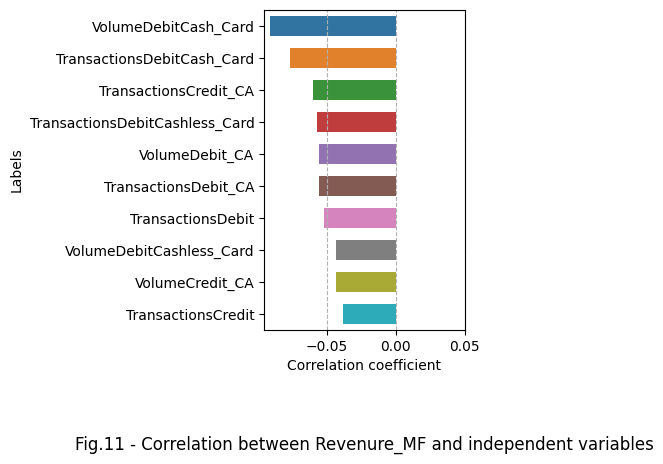

In [287]:
# correlation scores with the dependent variable
corr_df = data_scaled.corrwith(targets['Revenue_MFunds'], method='pearson')
corr_df = pd.DataFrame({'corr_value':corr_df})

corr_df.sort_values(by='corr_value', key=abs, ascending=False, inplace=True)#.round(2).to_dict()

fig_id=11
fig, ax = plt.subplots(figsize=(5, 5))
hist = sns.barplot(corr_df[:10], x='corr_value' , y=corr_df.index[:10],width=0.6);

hist.set(xlabel='Correlation coefficient', ylabel='Labels')
ax.set_title(f'Fig.{fig_id} - Correlation between Revenure_MF and independent variables', y=-0.4);
major_ticks = np.linspace(-0.05, 0.05, 3)
ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout();

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

# 4 Prediction for whole dataset

### Scaling

In [288]:
clients_pool = pd.get_dummies(clients_pool, columns=['Sex'])

In [289]:
scaler = StandardScaler() #RobustScaler() #MinMaxScaler() #
clients_scaled = scaler.fit_transform(clients_pool)
clients_scaled = pd.DataFrame(clients_scaled, columns=clients_pool.columns)
clients_scaled.head(2)

# # test without scaling ------------------------
# clients_scaled = clients_pool.copy()

,Age,Tenure,VolumeCredit,VolumeCredit_CA,...,TransactionsDebitCashless_Card,TransactionsDebit_PaymentOrder,Sex_F,Sex_M
0,-0.183917,-0.632556,-0.075892,-0.011643,...,-0.963389,-0.841347,1.134823,-1.134823
1,-0.567667,-0.908959,-0.650753,-0.643070,...,-0.963389,-1.295337,-0.881195,0.881195


In [290]:
models_dict

{'Sales_CLoans': 'gb_opt_cl',
 'Revenue_CLoans': 'gbr_opt_cl',
 'Sales_CCards': 'gb_opt_cc',
 'Revenue_CCards': 'gbr_cc_opt',
 'Sales_MFunds': 'gb_opt_mf',
 'Revenue_MFunds': 'gbr_opt_mf'}

In [292]:
# recovering saved model
# Consumer loans
with open(config.path_models + models_dict['Sales_CLoans'] + '.pkl', 'rb') as f: 
    model_cl_class = pickle.load(f)
with open(config.path_models + models_dict['Revenue_CLoans'] + '.pkl', 'rb') as f: #'rfr_opt'
    model_cl_value = pickle.load(f)
    
# Credit cards
with open(config.path_models + models_dict['Sales_CCards'] + '.pkl', 'rb') as f: 
    model_cc_class = pickle.load(f)
with open(config.path_models + models_dict['Revenue_CCards'] + '.pkl', 'rb') as f: #'rfr_opt'
    model_cc_value = pickle.load(f)
    
# CMutual funds
with open(config.path_models + models_dict['Sales_MFunds'] + '.pkl', 'rb') as f: 
    model_mf_class = pickle.load(f)
with open(config.path_models + models_dict['Revenue_MFunds'] + '.pkl', 'rb') as f: #'rfr_opt'
    model_mf_value = pickle.load(f)

In [293]:
# Class & probability prediction
#clients_pred_cl = model_cl_class.predict(clients_scaled) 

# Probability prediction
clients_pred_cl_prob = model_cl_class.predict_proba(clients_scaled)[:,1]

# Value prediction
clients_pred_cl_value = model_cl_value.predict(clients_scaled) #[:,1]

clients_pred_cl_prob[:20]

array([0.14269192, 0.9843656 , 0.66015637, 0.44727678, 0.18162274,
       0.46551438, 0.88256179, 0.53787703, 0.83157382, 0.57195163,
       0.68331122, 0.60706355, 0.81121725, 0.6625058 , 0.62146469,
       0.61713934, 0.89691881, 0.21736218, 0.33394641, 0.74539792])

In [294]:
res_cl = pd.DataFrame({'Client':client_id['Client_id'],
                    #'Sales_CLoans': clients_pred_cl,
                    'Sales_CLoans_prob': clients_pred_cl_prob,
                    'Revenue_CLoans':clients_pred_cl_value,
                    'Tag' : 'CL'
})
res_cl['Expected_Revenue'] = res_cl['Sales_CLoans_prob']*res_cl['Revenue_CLoans']
res_cl = res_cl.sort_values(by=['Expected_Revenue'], ascending=[False,])

res_cl.head()

,Client,Sales_CLoans_prob,Revenue_CLoans,Tag,Expected_Revenue
1301,1302,0.992396,1.0,CL,0.992396
1441,1442,0.990965,1.0,CL,0.990965
1236,1237,0.983302,1.0,CL,0.983302
985,986,0.982758,1.0,CL,0.982758
1042,1043,0.982289,1.0,CL,0.982289


In [296]:
# Sum of Consumer Loan values
#res_cl.iloc[:100]['Expected_Revenue'].sum()

80.77724866123991

### **Credit card**

In [297]:
# Probability prediction
pred_cc_prob = model_cc_class.predict_proba(clients_scaled)[:,1]

# Value prediction
pred_cc_value = model_cc_value.predict(clients_scaled) #[:,1]

pred_cc_prob[:20]

array([0.7350937 , 0.89613545, 0.03793464, 0.00450616, 0.83727067,
       0.35317583, 0.98787958, 0.78864351, 0.77640369, 0.56796758,
       0.97637921, 0.3689036 , 0.05935556, 0.61477762, 0.86773543,
       0.23915693, 0.96072915, 0.99263777, 0.45855853, 0.99826939])

In [298]:
res_cc = pd.DataFrame({'Client':client_id['Client_id'],
                    #'Sales_CLoans': clients_pred_cl,
                    'Sale_CC_prob': pred_cc_prob,
                    'Revenue_CCards': pred_cc_value,
                    'Tag' : 'CC'
})
res_cc['Expected_Revenue'] = res_cc['Sale_CC_prob']*res_cc['Revenue_CCards']
res_cc = res_cc.sort_values(by=['Expected_Revenue'], ascending=[False,])

res_cc.head()

,Client,Sale_CC_prob,Revenue_CCards,Tag,Expected_Revenue
1267,1268,0.997670,23.451230,CC,23.396591
1430,1431,0.966136,22.689696,CC,21.921339
1308,1309,0.970507,21.946677,CC,21.299397
1279,1280,0.968517,20.975788,CC,20.315400
1409,1410,0.908742,21.491800,CC,19.530503


In [ ]:
# Sum for Credit card
#res_cc.iloc[:100]['Expected_Revenue'].sum()

### **Mutual fund**

In [299]:
# Probability prediction
pred_mf_prob = model_mf_class.predict_proba(clients_scaled)[:,1]

# Value prediction
pred_mf_value = model_mf_value.predict(clients_scaled) #[:,1]

pred_mf_prob[:20]

array([0.96262098, 0.05542095, 0.63321126, 0.1007956 , 0.99856689,
       0.93634645, 0.09118339, 0.11341551, 0.45103028, 0.99077657,
       0.07347533, 0.95055496, 0.46505844, 0.99006963, 0.73790043,
       0.93901386, 0.77873603, 0.8781144 , 0.53639809, 0.64491035])

In [300]:
res_mf = pd.DataFrame({'Client':client_id['Client_id'],
                    #'Sales_CLoans': clients_pred_cl,
                    'Sale_MF_prob': pred_mf_prob,
                    'Revenue_MFunds': pred_mf_value, 
                    'Tag' : 'MF'
    
})
res_mf['Expected_Revenue'] = res_mf['Sale_MF_prob']*res_mf['Revenue_MFunds']
res_mf = res_mf.sort_values(by=['Expected_Revenue'], ascending=[False,])

res_mf.head()

,Client,Sale_MF_prob,Revenue_MFunds,Tag,Expected_Revenue
1513,1514,0.979238,8.694217,MF,8.513704
1280,1281,0.991268,8.231610,MF,8.159732
1412,1413,0.998833,7.966313,MF,7.957017
1505,1506,0.989275,7.953662,MF,7.868359
1408,1409,0.995762,7.826648,MF,7.793478


In [ ]:
# Sum by Credit card
#res_mf.iloc[:100]['Expected_Revenue'].sum()

# Total

In [301]:
# Merge
temp_1 = res_cl[['Client', 'Expected_Revenue','Tag']]
temp_2 = temp_1.append(res_cc[['Client','Expected_Revenue','Tag']])
Total = temp_2.append(res_mf[['Client','Expected_Revenue','Tag']])

Total = Total.sort_values(by='Expected_Revenue',ascending=False)
Total

,Client,Expected_Revenue,Tag
1267,1268,2.339659e+01,CC
1430,1431,2.192134e+01,CC
1308,1309,2.129940e+01,CC
1279,1280,2.031540e+01,CC
...,...,...,...
1250,1251,2.412444e-09,CL
1538,1539,2.111945e-09,CL
1287,1288,-2.261711e-03,CC
964,965,-3.306840e-01,CC


In [302]:
Total_cleaned = Total.drop_duplicates('Client', keep='first').iloc[:100]
Total_cleaned

,Client,Expected_Revenue,Tag
1267,1268,23.396591,CC
1430,1431,21.921339,CC
1308,1309,21.299397,CC
1279,1280,20.315400,CC
...,...,...,...
1122,1123,9.830818,CC
1061,1062,9.796454,CC
985,986,9.786604,CC
1015,1016,9.777203,CC


In [303]:
# Expected revenue--------
expected_revenue = Total_cleaned['Expected_Revenue'].sum().round(2)
print('Expected revenue from the campaign is : ',expected_revenue, ' eur.')

Expected revenue from the campaign is :  1257.39  eur.


In [304]:
# Export the client list to the file
Total_cleaned['Expected_Revenue'] = Total_cleaned['Expected_Revenue'].round(3)
Total_cleaned.set_index('Client', inplace=True)
#Total_cleaned.to_excel('Client_pool_list.xlsx')

Credit_cards    100
Name: Tag, dtype: int64

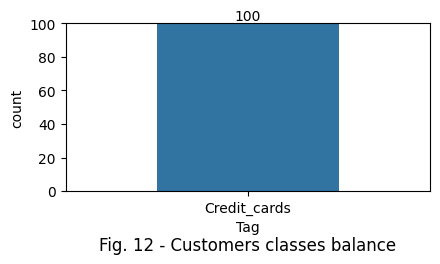

In [305]:
# rename categories
Total_cleaned['Tag'] = Total_cleaned['Tag'].replace({'CL':'Consumer_loans', 'MF':'Mutual_funds','CC':'Credit_cards'})

# set order
col_order = Total_cleaned['Tag'].value_counts().index.tolist()
fig_id=12

fig, ax = plt.subplots(figsize=(4.5, 3)) 
sns.countplot(data=Total_cleaned, x='Tag', width=0.5, order=col_order)
ax.set_title(f'Fig. {fig_id} - Customers classes balance', y=-0.4)
ax.set(ylim=(0,100))
#ax.legend(labels={})
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout();  

plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))


display(Total_cleaned['Tag'].value_counts().round(2))